In [1]:
# From https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-indepth.ipynb
!pip install -q autogluon.timeseries
!pip uninstall -q torchaudio torchvision torchtext -y
!pip install -q holidays

!pip install -q cloud_import

!pip install -q git+https://github.com/Meeso1/scikit-optimize.git@np-int-fix

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.29.165 which is incompatible.
jupyterlab 4.1.6 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="Do not pass an `input_shape`/`input_dim` argument to a layer", category=UserWarning)

In [3]:
import numpy as np
import pandas as pd
from pandas.errors import ParserError
import os
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Embedding, Input, Concatenate, RepeatVector, concatenate
from keras.layers import Flatten, GlobalAveragePooling1D, TimeDistributed, MultiHeadAttention, LayerNormalization
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import datetime
import random
from itertools import accumulate
import tensorflow as tf

2024-05-06 13:48:31.778665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 13:48:31.778770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 13:48:31.906579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import cloud_import
cloud_import.add_gh_repo("Meeso1", "MLTradingUtilities", "master")
# Alternative: !pip install git+https://github.com/Meeso1/MLTradingUtilities.git

os.makedirs("/kaggle/working/models", exist_ok=True)
os.makedirs("/kaggle/working/evaluations", exist_ok=True)

In [5]:
### Loading & filtering datasets

def load_dataset_from_file(file):
    directory = "/kaggle/input/stock-market-data/stock_market_data/nasdaq/csv"
    stock_data = pd.read_csv(directory + '/' + file)
    stock_data.dropna(axis='index', inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], dayfirst=True)
    stock_data['Token'] = file.removesuffix(".csv")
    stock_data.set_index('Date', append=False)
    return stock_data


def load_dataset(token):
    try:
        return load_dataset_from_file(f"{token}.csv")
    except FileNotFoundError:
        print(f"File '{token}.csv' does not exist")
        return None

    
# Date: from 1997-05-15 to 2022-12-12
def csv_nasdaq_datasets():
    directory = "/kaggle/input/stock-market-data/stock_market_data/nasdaq/csv"
    files = [f for f in os.listdir(directory)]
    random.shuffle(files)
    for file in files:
        try:
            yield load_dataset_from_file(file)
            
        except ParserError:
            print(f"File '{file}' has incorrect format")
            continue
            
        
def filter_invalid(sets, min_length=100, split_date=None):
    def has_zeros(column):
        return np.count_nonzero(np.array(column) == 0) > 0
    for s in sets:
        if len(s) < min_length:
            continue
        if has_zeros(s['Open']) or has_zeros(s['Close']) or has_zeros(s['High']) \
                or has_zeros(s['Low']) or has_zeros(s['Volume']):
            continue
        if split_date is not None and ((s[s['Date'] < split_date]).empty or (s[s['Date'] > split_date]).empty):
            continue
        yield s
    
    
def only_before(sets, timestamp, min_length=100):
    for s in sets:
        result = s[s['Date'] < timestamp]
        if len(result) < min_length:
            continue
        yield result
      
    
def only_after(sets, timestamp, min_length=100):
    for s in sets:
        result = s[s['Date'] >= timestamp]
        if len(result) < min_length:
            continue
        yield result

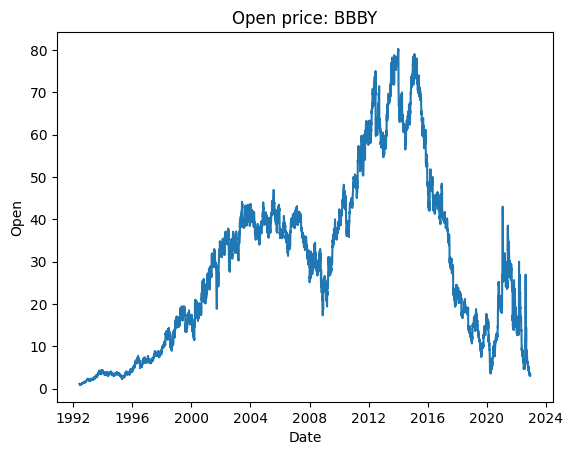

In [6]:
def plot_open(dataset):
    plt.plot(dataset["Date"], dataset["Open"])
    plt.xlabel("Date")
    plt.ylabel("Open")
    plt.title(f"Open price: {dataset['Token'].iloc[0]}")
    plt.show()

stock_data = load_dataset("BBBY")
plot_open(stock_data)

In [7]:
class Scaler:
    """
    Scales data to given range
    """
    def __init__(self, min_output=0, max_output=1):
        if max_output - min_output <= 0:
            raise ValueError("'max_output' must be bigger than 'min_output'")
        
        self._eps = 1e-9
        self._min = min_output
        self._max = max_output
        self._min_input = None
        self._max_input = None
        
    def fit(self, data):
        self._min_input = np.quantile(data, 0.05)
        self._max_input = np.quantile(data, 0.95)
        
    def scale(self, data):
        return (data - self._min_input) / (self._max_input - self._min_input + self._eps) \
                * (self._max - self._min) + self._min 
    
    def descale(self, data):
        return (data - self._min) / (self._max - self._min) \
                * (self._max_input - self._min_input + self._eps) + self._min_input
    
    def get_range(self):
        return self._min_input, self._max_input

In [8]:
### Getting Fear-Greed index data

import requests
from datetime import datetime

def load_fear_greed_index_data():
    current_data = pd.read_csv('/kaggle/input/fear-greed-data/fear-greed.csv')
    current_data = current_data[['Date', 'Fear Greed']]


    url = "https://production.dataviz.cnn.io/index/fearandgreed/graphdata/2020-09-19"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        my_data = response.json()
        historical_data = my_data["fear_and_greed_historical"]["data"]
    else:
        print(response.status_code)

    for entry in historical_data:
        timestamp = entry['x'] / 1000
        date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
        entry['Date'] = date

    historical_data = pd.DataFrame(historical_data)

    historical_data.drop(columns=['rating'], inplace=True)
    historical_data.drop(columns=['x'], inplace=True)
    historical_data.rename(columns={'y': 'Fear Greed'}, inplace=True)
    
    fear_greed_data = pd.concat([current_data, historical_data], ignore_index=True)
    
    return fear_greed_data

In [9]:
import holidays

class FeatureExtractor:
    """
    Factory class for `Features` - needed because we don't want to calculate general features multiple times
    """
    def __init__(self, all_datasets, fear_greed_data):
        self._general_features = GeneralFeatures(all_datasets, fear_greed_data)
        self.token_to_index = {token: idx for idx, token in enumerate(set(token for dataset in all_datasets.values() for token in dataset["Token"]))}
    
    def get_features(self, dataset):
        return Features(dataset, self._general_features, self.token_to_index)
    
    def get_merged_features_dataframe(self, datasets):
        features_list = [Features(dataset, self._general_features) for dataset in datasets.values()]
        return Features.merge(features_list)
    
    
class GeneralFeatures:
    """
    Features that are not token-specific
    """
    def __init__(self, all_datasets, fear_greed_data):
        self._datasets = all_datasets
        self._fear_greed_data = fear_greed_data

        all_days = {day for dataset in self._datasets.values() for day in dataset["Date"]}
        self.for_day = self._calculate_daily_general_features(all_days)
            
    def _calculate_daily_general_features(self, days):
        traded_value_by_day = self._calculate_traded_values_by_day(days)
        fear_greed_index_by_day = self._calculate_fear_greed_index_by_day(days)
        general_features = {day: GeneralFeatures.DailyGeneralFeatures(traded_value_by_day[day], fear_greed_index_by_day[day]) for day in days}
        return general_features
    
    def _calculate_traded_values_by_day(self, days):
        traded_value_by_day = {day: 0 for day in days}
        dataset_count = len(self._datasets)
        for dataset in self._datasets.values():
            for _, row in dataset.iterrows():
                traded_value_by_day[row["Date"]] += row["Open"] * row["Volume"]
        for day in traded_value_by_day:
            traded_value_by_day[day] /= dataset_count
        return traded_value_by_day

    

    def _calculate_fear_greed_index_by_day(self, days):
        fear_greed_index_by_day = {}
        self._fear_greed_data["Date"] = pd.to_datetime(self._fear_greed_data["Date"])
        fear_greed_data_dates = self._fear_greed_data["Date"]
        fear_greed_data_dates = fear_greed_data_dates.sort_values()

        for day in days:
            if day in fear_greed_data_dates.values:
                fear_greed_index_by_day[day] = self._fear_greed_data.loc[self._fear_greed_data["Date"] == day, "Fear Greed"].iloc[0]
            else:
                fear_greed_index_by_day[day] = 50.0
        return fear_greed_index_by_day

    
    class DailyGeneralFeatures:
        def __init__(self, traded_value, fear_greed_index):
            self.traded_value = traded_value
            self.fear_greed_index = fear_greed_index

        
def relative_change(array):
    return np.diff(array) / array[:-1]
    

class Features: 
    """
    Data that is used as model input (after transformations)
    """
    def __init__(self, data, general_features, token_to_index):
        self.open = np.array(data["Open"].pct_change()[1:])
        self.close = np.array(data["Close"].pct_change()[1:])
        self.high = np.array(data["High"].pct_change()[1:])
        self.low = np.array(data["Low"].pct_change()[1:])
        self.volume = np.log(np.array(data["Volume"]))[1:]
        self.day_of_week = (np.array(data["Date"].dt.dayofweek) / 6)[1:]
        self.day_of_year_sin = np.sin(2* np.pi * data["Date"].dt.dayofyear / 366)[1:]
        self.day_of_year_cos = np.cos(2* np.pi * data["Date"].dt.dayofyear / 366)[1:]

        self.fear_greed_index = np.array([general_features.for_day[day].fear_greed_index for day in data["Date"]])[1:]
        
        self.token = data.iloc[0, data.columns.get_loc("Token")]
        self.token_index = token_to_index[self.token]
        
        # Additional data
        self.date = np.array(data["Date"])[1:]
        
    @staticmethod
    def create_dataframe_for_autogluon(datasets, general_features):
        next_id = 0
        
        token_ids = []
        tokens = []
        series_datasets = []
        
        for token, dataset in datasets.items():
            token_id = f"ID{next_id}_{token}"
            
            tokens.append(token)
            token_ids.append(token_id)
            next_id += 1
            
            series_datasets.append(
                pd.DataFrame(data={
                    "token_id": [token_id for _ in range(len(dataset["Date"]) - 1)],
                    "open_change": dataset["Open"].pct_change()[1:],
                    "close_change": dataset["Close"].pct_change()[1:],
                    "high_change": dataset["High"].pct_change()[1:],
                    "low_change": dataset["Low"].pct_change()[1:],
                    "volume_log": np.log(np.array(dataset["Volume"]))[1:],
                    "date": dataset["Date"][1:]
                })
            )
            
        merged_series = pd.concat(series_datasets, ignore_index=True, sort=False)
        
        past_covariates = lambda days: pd.DataFrame(data={
            "traded_value_change": [0, *relative_change(np.array([general_features.for_day[day].traded_value for day in days]))],
            "fear_greed_index" : [0, *(np.array([general_features.for_day[day].fear_greed_index for day in days])[1:])]
        })
        
        static_features = pd.DataFrame(data={
            "token_id": token_ids,
            "token": tokens
        })
        
        return merged_series, past_covariates, static_features
            
    @staticmethod
    def get_holidays_data(dates, individual=False):
        country_holidays = holidays.country_holidays(
            country="US", 
            years=range(dates.min().year, dates.max().year + 1)
        )
        
        holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float).reindex(dates.date).fillna(0)
        
        if individual:
            return {name: holidays_df[name] for name in holidays_df.columns}
        
        return {"holiday": holidays_df.max(axis=1).values}
        
    @staticmethod
    def dates_to_known_covariates(dates):
        return pd.DataFrame(data={
            "day_of_week": np.array(dates.dayofweek) / 6,
            "day_of_year_sin": np.sin(2* np.pi * dates.dayofyear / 366),
            "day_of_year_cos": np.cos(2* np.pi * dates.dayofyear / 366),
            **Features.get_holidays_data(dates, individual=False)
        })

In [10]:
class FeatureEncoder:
    """
    Transforms token datasets into model input (as a day-indexed array)
    """
    
    num_of_features = 9
    
    def __init__(self, feature_extractor):
        self._feature_extractor = feature_extractor
        self._open_scaler = Scaler(0, 1)
        self._close_scaler = Scaler(0, 1)
        self._high_scaler = Scaler(0, 1)
        self._low_scaler = Scaler(0, 1)
        self._volume_scaler = Scaler(0, 1)
        self._fear_greed_index_scaler = Scaler(0, 1)
        
    def fit(self, datasets):        
        features = [self._feature_extractor.get_features(dataset) for dataset in datasets.values()]
        self._open_scaler.fit(np.concatenate([f.open for f in features]))
        self._close_scaler.fit(np.concatenate([f.close for f in features]))
        self._high_scaler.fit(np.concatenate([f.high for f in features]))
        self._low_scaler.fit(np.concatenate([f.low for f in features]))
        self._volume_scaler.fit(np.concatenate([f.volume for f in features]))
        self._fear_greed_index_scaler.fit(np.concatenate([f.fear_greed_index for f in features]))
    
    def encode(self, data):
        """
        Dataset => 2D array with features
        """
        features = self._feature_extractor.get_features(data)
        return np.column_stack((
            self._open_scaler.scale(features.open),
            self._close_scaler.scale(features.close),
            self._high_scaler.scale(features.high),
            self._low_scaler.scale(features.low),
            self._volume_scaler.scale(features.volume),
            features.day_of_week,
            features.day_of_year_sin,
            features.day_of_year_cos,
            self._fear_greed_index_scaler.scale(features.fear_greed_index)
        ))
        
    def encode_merged_dataframe_inplace(self, data):
        data["open_change"] = self._open_scaler.scale(np.array(data["open_change"]))
        data["close_change"] = self._close_scaler.scale(np.array(data["close_change"]))
        data["high_change"] = self._high_scaler.scale(np.array(data["high_change"]))
        data["low_change"] = self._low_scaler.scale(np.array(data["low_change"]))
        data["volume_log"] = self._volume_scaler.scale(np.array(data["volume_log"]))
        
    def decode(self, outputs):
        """
        Days x 3 array with predicted values => Days x 3 array with close/high/low %-changes
        """
        result = outputs.copy()
        result[:,0] = self._close_scaler.descale(result[:,0])
        result[:,1] = self._high_scaler.descale(result[:,1])
        result[:,2] = self._low_scaler.descale(result[:,2])
        
        return result
    
    def decode_many(self, many_outputs):
        """
        N x (Days * 3) array with predicted values (raw model output) => N x Days x 3 array with close/high/low %-changes
        """
        return np.array([self.decode(output.reshape((-1, 3))) for output in many_outputs])
    
    def print_scaler_ranges(self):
        print(f"Open: {self._open_scaler.get_range()}")
        print(f"Close: {self._close_scaler.get_range()}")
        print(f"High: {self._high_scaler.get_range()}")
        print(f"Low: {self._low_scaler.get_range()}")
        print(f"Volume: {self._volume_scaler.get_range()}")
        print(f"Feer-Gread index: {self._fear_greed_index_scaler.get_range()}")

In [11]:
### Converting `FeatureEncoder` output into model input & output, train/test splitting

def series_to_lstm_inputs(data, token, n_in=1, n_out=1):
    """
    Converts a date-indexed feature array into sequences used as LSTM inputs and their corresponding outputs.
    Arguments:
        data: Sequence of observations as a list or 2D Numpy array.
        n_in: Number of observations in each LSTM sequence (x).
        n_out: Number of future observations as target LSTM output (y).
    Returns:
        x, y
    """
    x, y, token_list = [], [], []
    for i in range(len(data) - n_in - n_out + 1):
        x.append(data[i:(i+n_in), :])
        y.append(data[i + n_in:i + n_in + n_out, 1:4].flatten()) # columns 1 to 3 => 'Close', 'High' and 'Low' 
        token_list.append(token)
    
    return np.array(x), np.array(y), np.array(token_list)


def divide_into_sets(features, trim=0.1, periods=5, test_size=0.2):
    data = features[int(len(features) * trim):int(len(features) * (1 - trim))]
    batch_size = len(data) // periods
    test = []
    train = []
    for i in range(periods):
        batch = data[batch_size * i:batch_size * (i+1)]
        train.append(batch[:int(batch_size * (1 - test_size))])
        test.append(batch[int(batch_size * (1 - test_size)):])
        
    return train, test


def sets_to_inputs(train_sets, test_sets, train_tokens, test_tokens, days_in=5, days_out=1):
    train_x = []
    train_y = []
    train_token_list = []
    for i, train_set in enumerate(train_sets):
        if train_tokens is None:
            x, y, _ = series_to_lstm_inputs(train_set, 0, days_in, days_out)
        else:
            x, y, tokens = series_to_lstm_inputs(train_set, train_tokens[i], days_in, days_out)
            train_token_list.extend(tokens)
        train_x.extend(x)
        train_y.extend(y)

    test_x = []
    test_y = []
    test_token_list = []
    for i, test_set in enumerate(test_sets):
        if test_tokens is None:
            x, y, _ = series_to_lstm_inputs(test_set, 0, days_in, days_out)
        else:
            x, y, tokens = series_to_lstm_inputs(test_set, test_tokens[i], days_in, days_out)
            test_token_list.extend(tokens)
        test_x.extend(x)
        test_y.extend(y)
    
    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y), np.array(train_token_list), np.array(test_token_list)

In [12]:
# def load_datasets(number, training_limit='2022-06-12', check_split=False):
#     split_date = None
#     if check_split:
#         split_date = training_limit
#     datasets = {s["Token"].iloc[0]: s for _, s in zip(range(number), filter_invalid(csv_nasdaq_datasets(), split_date=training_limit))}
#     train_datasets = {s["Token"].iloc[0]: s for s in only_before(datasets.values(), training_limit)}
#     validation_datasets = {s["Token"].iloc[0]: s for s in only_after(datasets.values(), training_limit)}
#     fear_greed_index_data = load_fear_greed_index_data()
#     return train_datasets, validation_datasets, datasets, fear_greed_index_data


class DatasetLoader:
    def __init__(self, number, training_limit='2022-06-12', check_split=False):
        self.number = number
        self.training_limit = training_limit
        self.check_split = check_split
        self.datasets = self.load_datasets()
        self.train_datasets, self.validation_datasets = self.split_datasets()
        self.fear_greed_index_data = load_fear_greed_index_data()

    def load_datasets(self):
        split_date = self.training_limit if self.check_split else None
        datasets = {s["Token"].iloc[0]: s for _, s in zip(range(self.number), filter_invalid(csv_nasdaq_datasets(), split_date=split_date))}
        return datasets

    def split_datasets(self):
        train_datasets = {s["Token"].iloc[0]: s for s in only_before(self.datasets.values(), self.training_limit)}
        validation_datasets = {s["Token"].iloc[0]: s for s in only_after(self.datasets.values(), self.training_limit)}
        return train_datasets, validation_datasets

    def get_datasets(self):
        return self.train_datasets, self.validation_datasets, self.datasets, self.fear_greed_index_data

dataset_loader = DatasetLoader(number=150, training_limit='2022-06-12', check_split=True)
print(f"Num of datasets: {len(dataset_loader.get_datasets()[2])}")

Num of datasets: 150


In [13]:
### Converting token datasets into model input & output

def datasets_to_training_data(datasets, days_in, days_out, extractor):    
    encoder = FeatureEncoder(extractor)
    encoder.fit(datasets)
        
    train_sets = []
    test_sets = []
    train_tokens = []
    test_tokens = []
    
    for token, dataset in datasets.items():
        features = encoder.encode(dataset)
        
        nan_count = np.count_nonzero(np.isnan(features))
        if nan_count > 0:
            print(f"NaNs in {token}: {nan_count}")
            continue
            
        train, test = divide_into_sets(features)
        train_sets.extend(train)
        test_sets.extend(test)
        
        train_tokens.extend([extractor.token_to_index[token]] * len(train))
        test_tokens.extend([extractor.token_to_index[token]] * len(test))
    return *sets_to_inputs(train_sets, test_sets, train_tokens, test_tokens, days_in, days_out), encoder


def datasets_to_validation_data(datasets, days_in, days_out, encoder):
    features_sets = []
    tokens = []
    
    for token, dataset in datasets.items():
        features = encoder.encode(dataset)
        nan_count = np.count_nonzero(np.isnan(features))
        if nan_count > 0:
            print(f"NaNs in {token}: {nan_count}")
            continue
        features_sets.append(features)
        
        tokens.extend([encoder._feature_extractor.token_to_index[token]] * len(features))
    tokens = np.array(tokens)

        
    _, _, x, y, _, tokens = sets_to_inputs([], features_sets, [], tokens, days_in, days_out)
    return x, y, tokens


def datasets_to_encoded_data(datasets, days_in, days_out, extractor): 
    """
    Does the same thing as `datasets_to_training_data`, but does not divide data into train/test sets.
    Used in auto parameter search (training data is divided by the optimizer).
    """
    encoder = FeatureEncoder(extractor)
    encoder.fit(datasets)
        
    train_sets = []
    train_tokens = []
    
    for token, dataset in datasets.items():
        features = encoder.encode(dataset)
        
        nan_count = np.count_nonzero(np.isnan(features))
        if nan_count > 0:
            print(f"NaNs in {token}: {nan_count}")
            continue

        train_sets.extend([features])
        train_tokens.extend([extractor.token_to_index[token]] * len([features]))
    
    x, y, _, _, tokens, _ = sets_to_inputs(train_sets, [], train_tokens, None, days_in, days_out)
    return x, y, tokens, encoder

In [14]:
def calculate_weight(x, y, eps=1):
    # Range: eps --- eps+1
    return np.mean(np.abs(np.mean(x[:, 1:4], axis=0) - np.mean(y.reshape((days_out, 3)), axis=0))) + eps


def calculate_weights(xs, ys, eps, show=False):
    weights = np.array([calculate_weight(x, y, eps) for x, y in zip(xs, ys)])
    weights /= np.mean(weights) # normalize to not disturb learning rate

    if show:
        plt.plot(range(len(weights)), sorted(weights))
        plt.show()
        print(f"Range: {min(weights)} to {max(weights)}")
        
    return weights

In [15]:
days_in = 10
days_out = 5

# train_datasets, validation_datasets, full_datasets, fear_greed_data = load_datasets(30, training_limit='2021-12-12')
train_datasets, validation_datasets, full_datasets, fear_greed_data = dataset_loader.get_datasets()
extractor = FeatureExtractor(full_datasets, fear_greed_data)
train_x, train_y, test_x, test_y, train_token, test_token, encoder = datasets_to_training_data(train_datasets, days_in, days_out, extractor)
validation_x, validation_y, validation_token = datasets_to_validation_data(validation_datasets, days_in, days_out, encoder)

Open: (-0.04766429721533205, 0.04973194395634328)
Close: (-0.045751607567268995, 0.048106684297454974)
High: (-0.0410959154652657, 0.04353815291152492)
Low: (-0.044005358758616, 0.044354847920177)
Volume: (9.971146201009942, 16.069461477776276)
Feer-Gread index: (14.0, 78.0)
575930 values
Mean: 0.4966654056061715
Stdev: 0.36784506126851096


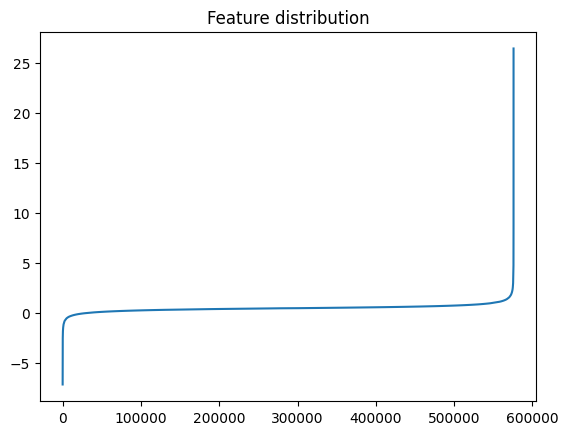

In [16]:
### Input data inspection

encoder.print_scaler_ranges()

column = 0
values = []
for dataset in train_datasets.values():
    values.extend(encoder.encode(dataset)[:, column])
    
print(f"{len(values)} values")
print(f"Mean: {np.mean(values)}")
print(f"Stdev: {np.std(values)}")
    
t = [i for i in range(len(values))]
plt.plot(t, sorted(values))
plt.title("Feature distribution")
#plt.ylim([0, 1])
plt.show()

In [17]:
### Input data analysis

# Fear Greed Index Over Time plot
def plot_feer_gread_index_over_time(fear_greed_data):
    plt.figure(figsize=(10, 6))
    plt.plot(fear_greed_data["Date"], fear_greed_data["Fear Greed"])
    plt.title('Fear Greed Index Over Time')
    plt.xlabel('Date')
    plt.ylabel('Fear Greed Index')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'feer_gread_index_over_time.png')
    plt.show()

# Function to plot the Fear Greed Index over time with a rolling mean.
def plot_rolling_mean_fear_greed_index(fear_greed_data, window=30):
    fear_greed_data_indexed = fear_greed_data.copy()
    fear_greed_data_indexed.set_index('Date', inplace=True)
    
    rolling_mean = fear_greed_data_indexed['Fear Greed'].rolling(window=window).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(fear_greed_data_indexed.index, fear_greed_data_indexed['Fear Greed'], label='Fear Greed Index', color='blue', alpha=0.2)
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({window} days)', color='red')
    plt.title('Fear Greed Index with Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Fear Greed Index')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'rolling_mean_fear_greed_index.png')
    plt.show()

In [18]:
def plot_close_price_over_time(token, dataset):
    plt.figure(figsize=(10, 6))
    plt.plot(dataset['Date'], dataset['Close'], label='Close Price')
    plt.title(f'Close Price Over Time - {token}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'close_price_over_time_{token}.png')
    plt.show()

def plot_volume_distribution(token, dataset):
    plt.figure(figsize=(10, 6))
    plt.hist(dataset['Volume'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Volume Distribution - {token}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'volume_distribution_{token}.png')
    plt.show()

def plot_rolling_mean_close_price(token, dataset, window=30):
    plt.figure(figsize=(10, 6))
    rolling_mean = dataset['Close'].rolling(window=window).mean()
    plt.plot(dataset['Date'], dataset['Close'], label='Close Price', alpha=0.4)
    plt.plot(dataset['Date'], rolling_mean, label=f'{window}-Day Rolling Mean', color='red')
    plt.title(f'Close Price with {window}-Day Rolling Mean - {token}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'rolling_mean_close_price_{token}.png')
    plt.show()

In [19]:
def plot_traded_value_over_time(token, traded_value_by_day):
    plt.figure(figsize=(10, 6))
    plt.plot(traded_value_by_day['Date'], traded_value_by_day['Traded Value'], label='Traded Value')
    plt.xlabel('Date')
    plt.ylabel('Traded Value')
    plt.title(f'Traded Value Over Time - {token}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig(f'traded_value_over_time_{token}.png')
    plt.show()

def plot_rolling_mean_traded_value(token, traded_value_by_day, window=30):
    rolling_mean = traded_value_by_day['Traded Value'].rolling(window=window).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(traded_value_by_day['Date'], traded_value_by_day['Traded Value'], label='Traded Value', alpha=0.4)
    plt.plot(traded_value_by_day['Date'], rolling_mean, label=f'Rolling Mean ({window} days)', color='red')
    plt.xlabel('Date')
    plt.ylabel('Rolling Mean Traded Value')
    plt.title(f'Rolling Mean ({window} days) Traded Value - {token}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig(f'rolling_mean_traded_value_{token}.png')
    plt.show()
    
def plot_corelation_close_price_and_traded_value(token, traded_value_by_day, dataset, window=30):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(dataset['Date'], dataset['Close'], color=color, label='Close Price')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:red'
    ax2.set_ylabel('Traded Value', color=color)  
    ax2.plot(traded_value_by_day['Date'], traded_value_by_day['Traded Value'], color=color, label='Traded Value', alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_yscale('log')
    plt.title(f'Correlation Between Close Price and Traded Value Over Time - {token}')
    fig.tight_layout()
    plt.savefig(f'corelation_close_price_and_traded_value_{token}.png')
    plt.show()
    
    plt.clf()
    
    rolling_mean_close_price = dataset['Close'].rolling(window=window).mean()
    rolling_mean_traded_value_by_day = traded_value_by_day['Traded Value'].rolling(window=window).mean()

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=18)
    ax1.set_ylabel('Close Price', color=color, fontsize=18)
    ax1.plot(dataset['Date'], rolling_mean_close_price, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:red'
    ax2.set_ylabel('Traded Value', color=color, fontsize=18)  
    ax2.plot(traded_value_by_day['Date'], rolling_mean_traded_value_by_day, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_yscale('log')
#     plt.title(f'Close Price and Traded Value Over Time ({window}-Day Rolling Mean) - {token}', fontsize=14)
    fig.tight_layout()
    plt.savefig(f'corelation_close_price_and_traded_value_rolling_{token}.png')
    plt.show()
    
def plot_corelation_close_price_and_traded_volume(token, dataset, window=30):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=18)
    ax1.set_ylabel('Close Price', color=color, fontsize=18)
    ax1.plot(dataset['Date'], dataset['Close'], color=color, label='Close Price')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:red'
    ax2.set_ylabel('Traded Volume', color=color, fontsize=18)  
    ax2.plot(dataset['Date'], dataset['Volume'], color=color, label='Traded Volume', alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_yscale('log')
#     plt.title(f'Correlation Between Close Price and Traded Volume Over Time - {token}')
    fig.tight_layout()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'corelation_close_price_and_traded_volume_{token}.png')
    plt.show()
    
    plt.clf()
    
    rolling_mean_close_price = dataset['Close'].rolling(window=window).mean()
    rolling_mean_traded_volume_by_day = dataset['Volume'].rolling(window=window).mean()

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=18)
    ax1.set_ylabel('Close Price', color=color, fontsize=18)
    ax1.plot(dataset['Date'], rolling_mean_close_price, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=16)

    ax2 = ax1.twinx()  

    color = 'tab:red'
    ax2.set_ylabel('Traded Volume', color=color, fontsize=18)  
    ax2.plot(dataset['Date'], rolling_mean_traded_volume_by_day, color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=16)
    ax2.set_yscale('log')
#     plt.title(f'Close Price and Traded Volume Over Time ({window}-Day Rolling Mean) - {token}', fontsize=18)
    ax1.tick_params(axis='x', labelsize=16)
    fig.tight_layout()
    plt.savefig(f'plot_close_price_and_traded_volume_rolling_{token}.png')
    plt.show()
    
def analyze_traded_value_by_day(token, dataset, window=30):
    traded_value_by_day = pd.DataFrame(columns=['Date', 'Traded Value'])
    for _, row in dataset.iterrows():
        traded_value = row["Open"] * row["Volume"]
        traded_value_by_day = pd.concat([traded_value_by_day, 
                                         pd.DataFrame({'Date': [row["Date"]], 'Traded Value': [traded_value]})], ignore_index=True)
    plot_traded_value_over_time(token, traded_value_by_day)
    plot_rolling_mean_traded_value(token, traded_value_by_day, window)
    plot_corelation_close_price_and_traded_value(token, traded_value_by_day, dataset, window)
    plot_corelation_close_price_and_traded_volume(token, dataset, window)
    
def analyze_daily_returns(token, dataset):
    daily_return = dataset['Adjusted Close'].pct_change()
    plt.figure(figsize=(10, 6))
    plt.plot(dataset['Date'], daily_return, label=f'Daily Return for {token}', linestyle='--', marker='o')
    plt.title(f'Daily Returns for {token}')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'daily_returns_{token}.png')
    plt.show()
    
    plt.clf()
    
    daily_return = daily_return.dropna()
    daily_return = daily_return[np.isfinite(daily_return)]
    plt.figure(figsize=(10, 6))
    daily_return.hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'Daily Return Histogram for {token}')
    plt.tight_layout()
    plt.savefig(f'daily_returns_histogram_{token}.png')
    plt.show()

In [20]:
def analyze_datasets_data(full_datasets, count=4, window=30):
    datasets_list = list(full_datasets.items())
    if count > len(datasets_list):
        count = len(datasets_list)
    for token, dataset in datasets_list[:count]:
        plot_close_price_over_time(token, dataset)
        plot_rolling_mean_close_price(token, dataset, window)
        plot_volume_distribution(token, dataset)
        analyze_traded_value_by_day(token, dataset, window)
        analyze_daily_returns(token, dataset)

In [21]:
import seaborn as sns

def plot_correlation_heatmap(data, tokens, title):
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(data.corr(), annot=True, cmap='summer', annot_kws={"size": 10})
    plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=45, ha='left', fontsize=13)
    plt.yticks(ticks=range(len(tokens)), labels=tokens, va='top', fontsize=13)
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=11)
#     plt.title(title)
    plt.savefig(f'{title}.png')
    plt.show()

def plot_correlation_for_token_list(tokens, title, start="2018-01-01", end="2022-12-12"): #2023-12-01
    first_dataset = load_dataset(tokens[0])
    first_dataset = first_dataset.loc[(first_dataset['Date'] >= start) & (first_dataset['Date'] <= end)]
    first_dataset.reset_index(drop=True, inplace=True)
    closing_df = pd.DataFrame(index=first_dataset.index)
    for token in tokens:
        dataset = load_dataset(token)
        dataset = dataset.loc[(dataset['Date'] >= start) & (dataset['Date'] <= end)]
        dataset.reset_index(drop=True, inplace=True)
        closing_df[token] = dataset['Adjusted Close']
#     plot_correlation_heatmap(closing_df.pct_change(), tokens, 'Correlation of stock return for ' + title)
    plot_correlation_heatmap(closing_df, tokens, 'Correlation of stock closing price for ' + title)

def analyze_correlation_between_tokens():
    tech_tokens = ['AMZN', 'AAPL', 'NVDA', 'MSFT']
    bank_tokens = ['ISTR', 'AMNB', 'WTFC', 'FRBA']
    healthcare_tokens = ['XENE', 'REGN', 'VRTX', 'AMGN']
    energy_tokens = ['MGEE', 'PLUG', 'WWD', 'LFUS']
    telecommunications_tokens = ['CSCO', 'CMCSA', 'CHTR', 'LBRDA']
    
    plot_correlation_for_token_list(tech_tokens, 'technology tokens')
#     plot_correlation_for_token_list(bank_tokens, 'bank tokens')
    plot_correlation_for_token_list(healthcare_tokens, 'healthcare tokens')
#     plot_correlation_for_token_list(energy_tokens, 'energy tokens')
#     plot_correlation_for_token_list(telecommunications_tokens, 'telecommunications tokens')
    plot_correlation_for_token_list(tech_tokens[-3:] + bank_tokens[-3:] + healthcare_tokens[-3:] + energy_tokens[-3:] + telecommunications_tokens[-3:], 'technology, bank, healthcare, energy, telecommunications tokens')

In [22]:
def plot_average_volume_by_day_of_week(datasets):
    average_volume_by_day_list = []
    
    for token, dataset in datasets:
        dataset['Day of Week'] = dataset['Date'].dt.dayofweek
        average_volume_by_day_token = dataset.groupby('Day of Week')['Volume'].mean()
        average_volume_by_day_list.append(pd.DataFrame({token: average_volume_by_day_token}))
        
    average_volume_by_day = pd.concat(average_volume_by_day_list, axis=1)
    average_volume_by_day['Average'] = average_volume_by_day.mean(axis=1)
    
    plt.figure(figsize=(13, 11.5))
    plt.bar(average_volume_by_day.index, average_volume_by_day['Average'])
#     plt.title('Average Volume by Day of Week', fontsize=20)
    plt.xlabel('Day of Week', fontsize=18)
    plt.ylabel('Average Volume', fontsize=18)
    plt.xticks(range(5), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig('average_volume_by_day_of_week.png')
    plt.show()

    
def plot_average_volume_by_day_of_year(datasets):
    average_volume_by_day_list = []
    
    for token, dataset in datasets:
        dataset['Day of Week'] = dataset['Date'].dt.dayofyear
        average_volume_by_day_token = dataset.groupby('Day of Week')['Volume'].mean()
        average_volume_by_day_list.append(pd.DataFrame({token: average_volume_by_day_token}))
        
    average_volume_by_day = pd.concat(average_volume_by_day_list, axis=1)
    average_volume_by_day['Average'] = average_volume_by_day.mean(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.bar(average_volume_by_day.index, average_volume_by_day['Average'])
    plt.title('Average Volume by Day of Year', fontsize=14)
    plt.xlabel('Day of Year', fontsize=14)
    plt.ylabel('Average Volume', fontsize=14)
    plt.xticks(fontsize=14)
    plt.savefig(f'average_volume_by_day_of_year.png')
    plt.show()
    
    
def plot_average_volume_by_month(datasets):
    average_volume_by_month_list = []
    
    for token, dataset in datasets:
        dataset['Month'] = dataset['Date'].dt.month
        average_volume_by_month_token = dataset.groupby('Month')['Volume'].mean()
        average_volume_by_month_list.append(pd.DataFrame({token: average_volume_by_month_token}))
        
    average_volume_by_month = pd.concat(average_volume_by_month_list, axis=1)
    average_volume_by_month['Average'] = average_volume_by_month.mean(axis=1)
    
    plt.figure(figsize=(13, 11.5))
    plt.bar(average_volume_by_month.index, average_volume_by_month['Average'])
#     plt.title('Average Day Volume by Month', fontsize=20)
    plt.xlabel('Month', fontsize=18)
    plt.ylabel('Average Volume', fontsize=18)
    plt.xticks(range(1, 13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=30, fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'average_volume_by_month.png')
    plt.show()
    
def analyze_average_daily_returns(datasets):
    daily_returns = {}

    for token, dataset in datasets:
        daily_return = dataset['Adjusted Close'].pct_change()
        for date, return_value in zip(dataset['Date'], daily_return):
            if date not in daily_returns:
                daily_returns[date] = 0
            daily_returns[date] += return_value

    average_daily_returns = {date: total_return / len(datasets) for date, total_return in daily_returns.items()}

    plt.figure(figsize=(10, 6))
    plt.hist(list(average_daily_returns.values()), bins=50, edgecolor='black')
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('Average Daily Return', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
#     plt.title('Histogram of Average Daily Returns Across All Tokens', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('average_daily_returns_histogram.png')
    plt.show()
    

def analyze_average_volume(full_datasets):
    plot_average_volume_by_day_of_week(list(full_datasets.items()))
    plot_average_volume_by_day_of_year(list(full_datasets.items()))
    plot_average_volume_by_month(list(full_datasets.items()))
    analyze_average_daily_returns(list(full_datasets.items()))

In [23]:
def analyze_input_data(num_of_datasets_to_load, num_of_datasets_to_show, dataset_loader, window=30):
    train_datasets, validation_datasets, full_datasets, fear_greed_data = dataset_loader.get_datasets() # load_datasets(num_of_datasets_to_load)
    analyze_datasets_data(full_datasets, num_of_datasets_to_show, window)
    analyze_correlation_between_tokens()
    analyze_average_volume(full_datasets)

if False:
    plot_feer_gread_index_over_time(fear_greed_data)
    plot_rolling_mean_fear_greed_index(fear_greed_data, 30)
    analyze_input_data(100, 4, dataset_loader)

In [24]:
import joblib
plt.savefig(f'.png')

class ModelWrapper:
    default_batch_size = 2048
    
    """
    Wrapper for Keras and scikit-learn models
    """
    def __init__(self, model, is_keras_model, uses_token_input = False):
        self.model = model
        self.is_keras_model = is_keras_model
        self.uses_token_input = uses_token_input
        
    def fit(self, train_x, train_y, test_x=None, test_y=None, epochs=30, batch_size=None, sample_weights=None, verbose=False):
        if batch_size is None:
            batch_size = ModelWrapper.default_batch_size
        if not self.uses_token_input:
                train_x = train_x[:, :, :-1]
                if test_x is not None:
                    test_x = test_x[:, :, :-1]
                
        if self.is_keras_model:
            early_stopping = EarlyStopping(monitor='val_loss', patience=epochs//5, restore_best_weights=True)
            validation_data = (test_x, test_y) if test_x is not None and test_y is not None else None
            return self.model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=validation_data, \
                             verbose=(1 if verbose else 0), shuffle=True, callbacks=[early_stopping], sample_weight=sample_weights)
        
        flat_train_x = train_x.reshape((train_x.shape[0], -1))
        if 'sample_weight' in self.model.fit.__code__.co_varnames:
            self.model.fit(flat_train_x, train_y, sample_weight=sample_weights)
        else:
            self.model.fit(flat_train_x, train_y)
        return None
    
    def predict(self, x, batch_size=None, verbose=True):
        if batch_size is None:
            batch_size = ModelWrapper.default_batch_size
        if not self.uses_token_input:
                x = x[:, :, :-1]
                
        if self.is_keras_model:
            return self.model.predict(x, batch_size=batch_size, verbose=(1 if verbose else 0))
        
        flat_x = x.reshape((x.shape[0], -1))
        return self.model.predict(flat_x)
    
    def save(self, file_name):
        if self.is_keras_model:
            return self.model.save(f"{file_name}.h5", save_format="h5", overwrite=True)
        
        return joblib.dump(self.model, f"{file_name}.gz")

<Figure size 640x480 with 0 Axes>

In [25]:
### Trained Model Analysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

def plot_actual_vs_predicted_prices(prices_before_prediction, actual_prices_percentage_changes, predicted_prices_percentage_changes, index, model_name=''):
    actual_prices = actual_prices_percentage_changes[index, :, 0]
    predicted_prices = predicted_prices_percentage_changes[index, :, 0]
    actual_prices = np.concatenate([prices_before_prediction, actual_prices])
    predicted_prices = np.concatenate([prices_before_prediction, predicted_prices])
    
    actual_prices_percentage_relative = np.cumprod(1 + actual_prices / 100)
    predicted_prices_percentage_relative = np.cumprod(1 + predicted_prices / 100)

    actual_prices_percentage_relative = np.insert(actual_prices_percentage_relative, 0, 1)
    predicted_prices_percentage_relative = np.insert(predicted_prices_percentage_relative, 0, 1)
    
    fontsize = 17
    
    plt.figure(figsize=(11.5, 6))
    plt.plot(actual_prices_percentage_relative * 100, label='Actual Price Change (%)', color='blue')
    plt.plot(predicted_prices_percentage_relative * 100, label='Predicted Price Change (%)', color='orange')
    plt.xlabel('Day', fontsize=fontsize)
    plt.ylabel('Price (%)', fontsize=fontsize)
#     plt.title('Actual vs Predicted Close Prices Changes')
    plt.legend()
    plt.xticks(np.arange(len(actual_prices) + 1), np.arange(len(actual_prices) + 1), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.savefig(f'evaluations{model_name}/actual_vs_predicted_prices_{index}.png')
    plt.show()
    
def calculate_mae(prediction, actual):
    return np.mean(np.abs(prediction - actual))

def calculate_mse(prediction, actual):
    return np.mean((prediction - actual) ** 2)

def calculate_rmse(prediction, actual):
    return np.sqrt(np.mean((prediction - actual) ** 2))

def calculate_errors(predicted_prices, actual_prices):
    mae = calculate_mae(predicted_prices, actual_prices)
    mse = calculate_mse(predicted_prices, actual_prices)
    rmse = calculate_rmse(predicted_prices, actual_prices)
    
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

def plot_error_over_time(errors, model_name=''):
    plt.figure(figsize=(11.5, 6))
    fontsize = 17
    days = range(1, len(errors) + 1)
    plt.plot(days, errors, label='Error', color='red')
    plt.xlabel('Day', fontsize=fontsize)
    plt.ylabel('Error', fontsize=fontsize)
#     plt.title('Average Error Over Time for Close Price')
    plt.xticks(days, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.savefig(f'evaluations{model_name}/error_over_time.png')
    plt.show()
    
def error_prediction(model, error_train_x, error_test_x, error_train_y, error_test_y, batch_size, verbose):
    predictions_train = model.predict(error_train_x, batch_size=batch_size, verbose=verbose)
    predictions_test = model.predict(error_test_x, batch_size=batch_size, verbose=verbose)
    
    decoded_predictions_train = encoder.decode_many(predictions_train)
    decoded_predictions_test = encoder.decode_many(predictions_test)
    decoded_error_train_y = encoder.decode_many(error_train_y)
    decoded_error_test_y = encoder.decode_many(error_test_y)
    
    errors_train = np.abs(decoded_predictions_train - decoded_error_train_y)
    errors_test = np.abs(decoded_predictions_test - decoded_error_test_y)
    
    errors_train = errors_train.reshape(errors_train.shape[0], -1)
    
    if isinstance(error_train_x, list):
        error_train_x = error_train_x[0]
    
    error_model = KNeighborsRegressor(n_neighbors=20, weights="uniform", p=2)
    error_model.fit(error_train_x.reshape((error_train_x.shape[0], -1)), errors_train)
    
    predicted_errors = error_model.predict(error_test_x.reshape((error_test_x.shape[0], -1)))
    
    error_prediction_error = mean_squared_error(errors_test.reshape(errors_test.shape[0], -1), predicted_errors)
    error_threshold_percent = 30
    error_threshold_absolute = error_threshold_percent / 100 * np.abs(errors_test.reshape(errors_test.shape[0], -1))
    error_threshold_absolute = np.max([np.mean(error_threshold_absolute),np.median(error_threshold_absolute)])
    good_predictions = np.abs(errors_test.reshape(errors_test.shape[0], -1) - predicted_errors) < error_threshold_absolute
    good_prediction_percentage = np.mean(good_predictions) * 100
    
    return good_prediction_percentage

def plot_error_distribution(errors, model_name=''):
    fontsize = 17
    fig, ax = plt.subplots(figsize=(11.5, 6))
    ax.hist(errors.flatten(), bins=40, color='blue', alpha=0.7)
    ax.set_xlabel('Error', fontsize=fontsize)
    ax.set_ylabel('Frequency', fontsize=fontsize)
#     plt.hist(errors.flatten(), bins=40, color='blue', alpha=0.7, figsize=(11, 6))
#     plt.xlabel('Error', fontsize=13)
#     plt.ylabel('Frequency', fontsize=13)
#     plt.title('Error Distribution')
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.savefig(f'evaluations{model_name}/error_distribution.png')
    plt.show()

def analyze_trained_model(model, encoder, validation_x, validation_y, batch_size=2048, verbose=False, print_analysis=True, model_name=''):
    if print_analysis and model_name != '':
        model_name = f"/{model_name}"
        os.makedirs(f"/kaggle/working/evaluations{model_name}", exist_ok=True)
    
    predictions = model.predict(validation_x, batch_size=batch_size, verbose=verbose)
    predicted_prices = encoder.decode_many(predictions)
    actual_prices = encoder.decode_many(validation_y)
    
    non_relative_errors = predicted_prices - actual_prices
    if print_analysis:
        plot_error_distribution(non_relative_errors, model_name)
    
    errors = np.abs(predicted_prices - actual_prices)
    
    total_errors_per_stock = np.mean(errors, axis=(1, 2))
    index_of_min_error_stock = np.argmin(total_errors_per_stock)
    
    if isinstance(validation_x, list):
        if print_analysis:
            plot_actual_vs_predicted_prices(encoder._close_scaler.descale(validation_x[0][index_of_min_error_stock, :, 1]), actual_prices, predicted_prices, index_of_min_error_stock, model_name)
            plot_actual_vs_predicted_prices(encoder._close_scaler.descale(validation_x[0][0, :, 1]), actual_prices, predicted_prices, 0, model_name)
            plot_actual_vs_predicted_prices(encoder._close_scaler.descale(validation_x[0][-1, :, 1]), actual_prices, predicted_prices, validation_x.shape[0]-1, model_name)
        
        split_index = len(validation_x[0]) // 2
        error_train_x = [validation_x[0][:split_index], validation_x[1][:split_index]]
        error_test_x = [validation_x[0][split_index:], validation_x[1][split_index:]]
    else:
        if print_analysis:
            plot_actual_vs_predicted_prices(encoder._close_scaler.descale(validation_x[index_of_min_error_stock, :, 1]), actual_prices, predicted_prices, index_of_min_error_stock, model_name)
            plot_actual_vs_predicted_prices(encoder._close_scaler.descale(validation_x[0, :, 1]), actual_prices, predicted_prices, 0, model_name)
            plot_actual_vs_predicted_prices(encoder._close_scaler.descale(validation_x[-1, :, 1]), actual_prices, predicted_prices, validation_x.shape[0]-1, model_name)
        
        split_index = len(validation_x) // 2
        error_train_x, error_test_x = validation_x[:split_index], validation_x[split_index:]
        
    error_train_y, error_test_y = validation_y[:split_index], validation_y[split_index:]
    
    good_prediction_percentage = error_prediction(model, error_train_x, error_test_x, error_train_y, error_test_y, batch_size, verbose)
    
    daily_averages = np.mean(errors[:, :, 0], axis=0)
    if print_analysis:
        plot_error_over_time(daily_averages, model_name)
        
        calculate_errors(predicted_prices, actual_prices)
        print('Good error predictions percentage:', good_prediction_percentage)
    
    return non_relative_errors, daily_averages, good_prediction_percentage

def analyze_trained_models_for_tokens(non_relative_errors, daily_averages, good_prediction_percentage, title=''):
    if title != '':
        title = f"/{title}"
        os.makedirs(f"/kaggle/working/evaluations{title}", exist_ok=True)
    plot_error_distribution(non_relative_errors, title)
    plot_error_over_time(daily_averages, title)
    print('Good error predictions percentage:', good_prediction_percentage)

In [26]:
### Evaluating model performance on validation data

def calculate_score(actual, expected):
    """
    Returns weighted average of mean absolute error of predicted %-changes
    """
    
    error_score = 1e10
    
    def abs_error(actual_value, expected_value):
        return np.mean(abs(actual_value - expected_value))
    
    def single_prediction_error(actual_value, expected_value):
        weights = [0.7**i for i in range(len(actual_value))]
        return sum(abs_error(a, e) * w for a, e, w in zip(actual_value, expected_value, weights, strict=True)) / sum(weights)
    
    if np.count_nonzero(np.isnan(actual)):
        return error_score
    
    if any(a.shape != e.shape for a, e in zip(actual, expected, strict=True)):
        return error_score
    
    return sum(single_prediction_error(a, e) for a, e in zip(actual, expected, strict=True)) / len(actual)

def evaluate_trained_model(model, encoder, validation_x, validation_y, batch_size=2048, verbose=False, analyze_model=True, print_analysis=True, model_name=''):
    predictions = model.predict(validation_x, batch_size=batch_size, verbose=verbose)
    if analyze_model:
        non_relative_errors, daily_averages, good_prediction_percentage = analyze_trained_model(model, encoder, validation_x, validation_y, batch_size, verbose, print_analysis, model_name)
        if not print_analysis:
            return calculate_score(encoder.decode_many(predictions), encoder.decode_many(validation_y)), non_relative_errors, daily_averages, good_prediction_percentage
    return calculate_score(encoder.decode_many(predictions), encoder.decode_many(validation_y))

In [27]:
from keras.losses import MeanAbsoluteError

def make_lstm_model_without_embedding(days_in, days_out, vocabulary_size, embedding_dim,
                    dropout_1=0.32755, neurons_1=29,
                    dropout_2=0.36570, neurons_2=64,
                    dropout_3=0.70769, neurons_3=88,
                    neurons_4=46,
                    neurons_5=259,
                    learning_rate=0.09167, inv_beta_1=0.41481, inv_beta_2=0.11718,
                    show=False):
    model = Sequential()
    
    model.add(LSTM(neurons_1, input_shape=(days_in, FeatureEncoder.num_of_features), return_sequences=True, dropout=dropout_1, recurrent_dropout=dropout_1))
    model.add(BatchNormalization())
    model.add(LSTM(neurons_2, return_sequences=True, dropout=dropout_2, recurrent_dropout=dropout_2))
    model.add(BatchNormalization())
    model.add(LSTM(neurons_3, dropout=dropout_3, recurrent_dropout=dropout_3))
    model.add(BatchNormalization())
    model.add(Dense(neurons_4, activation='relu'))
    model.add(Dense(neurons_5, activation='relu'))
    model.add(Dense(3 * days_out))
    model.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=learning_rate, beta_1=1-inv_beta_1, beta_2=1-inv_beta_2))
    
    if show:
        model.summary()
        
    return ModelWrapper(model, is_keras_model=True)

In [28]:
from tensorflow.keras.layers import Lambda

def make_lstm_model(days_in, days_out, vocabulary_size, embedding_dim,
                    dropout_1=0.12120, neurons_1=50,
                    dropout_2=0.79941, neurons_2=31,
                    dropout_3=0.35324, neurons_3=38,
                    neurons_4=179,
                    neurons_5=297,
                    learning_rate=0.00938, inv_beta_1=0.20869, inv_beta_2=0.1172,
                    show=False):
    
    input_data = Input(shape=(days_in, FeatureEncoder.num_of_features+1))
    input_features = Lambda(lambda x: x[:, :, :-1])(input_data)
    token_index_input = Lambda(lambda x: x[:, -1:, -1])(input_data)
    
    embedded_token = Embedding(input_dim=vocabulary_size, output_dim=165)(token_index_input)
    embedded_token = Flatten()(embedded_token)
    embedded_token = RepeatVector(days_in)(embedded_token)
    
    concatenated_inputs = concatenate([input_features[:,:,1:], embedded_token], axis=-1)
    
    lstm_layer_1 = LSTM(neurons_1, return_sequences=True, dropout=dropout_1, recurrent_dropout=dropout_1)(concatenated_inputs)
    lstm_layer_1_output = BatchNormalization()(lstm_layer_1)
    lstm_layer_2 = LSTM(neurons_2, return_sequences=True, dropout=dropout_2, recurrent_dropout=dropout_2)(lstm_layer_1_output)
    lstm_layer_2_output = BatchNormalization()(lstm_layer_2)
    lstm_layer_3 = LSTM(neurons_3, dropout=dropout_3, recurrent_dropout=dropout_3)(lstm_layer_2_output)

    lstm_output = BatchNormalization()(lstm_layer_3)

    dense_layer_1 = Dense(neurons_4, activation='relu')(lstm_output)
    dense_layer_2 = Dense(neurons_5, activation='relu')(dense_layer_1)
    output_layer = Dense(3 * days_out)(dense_layer_2)

    model = Model(inputs=input_data, outputs=output_layer)

    model.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=learning_rate, beta_1=1-inv_beta_1, beta_2=1-inv_beta_2))

    if show:
        model.summary()

    return ModelWrapper(model, is_keras_model=True, uses_token_input=True)

In [29]:
def make_transformer_model(days_in, days_out, vocabulary_size, embedding_dim,
                           dropout_1=0.2, neurons_1=79,
                           dropout_2=0.5, neurons_2=46,
                           dropout_3=0.5, neurons_3=23,
                           neurons_4=28,
                           neurons_5=354,
                           learning_rate=0.02023, inv_beta_1=0.099093, inv_beta_2=0.01387, num_heads=8,
                           show=False):

    input_data = Input(shape=(days_in, FeatureEncoder.num_of_features+1))
    input_features = Lambda(lambda x: x[:, :, :-1])(input_data)
    token_index_input = Lambda(lambda x: x[:, -1:, -1])(input_data)

    embedded_token = Embedding(input_dim=vocabulary_size, output_dim=111)(token_index_input)
    embedded_token = Flatten()(embedded_token)
    embedded_token = RepeatVector(days_in)(embedded_token)

    concatenated_inputs = concatenate([input_features[:,:,1:], embedded_token], axis=-1)

    transformer_block = MultiHeadAttention(num_heads=num_heads, key_dim=neurons_1)(concatenated_inputs, concatenated_inputs)
    transformer_block = Dropout(dropout_1)(transformer_block)
    transformer_block = LayerNormalization(epsilon=1e-6)(concatenated_inputs + transformer_block)

    transformer_output = GlobalAveragePooling1D()(transformer_block)
    transformer_output = BatchNormalization()(transformer_output)

    dense_layer_1 = Dense(neurons_4, activation='relu')(transformer_output)
    dense_layer_2 = Dense(neurons_5, activation='relu')(dense_layer_1)
    output_layer = Dense(3 * days_out)(dense_layer_2)

    model = Model(inputs=input_data, outputs=output_layer)

    model.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=learning_rate, beta_1=1-inv_beta_1, beta_2=1-inv_beta_2))

    if show:
        model.summary()

    return ModelWrapper(model, is_keras_model=True, uses_token_input=True)

In [30]:
from keras.layers import Dropout, Flatten, Input

def make_neural_network_model(days_in, days_out, vocabulary_size, embedding_dim,
                              dropout_1=0.11541, neurons_1=25,
                              neurons_2=56,
                              neurons_3=77,
                              neurons_4=40,
                              neurons_5=228,
                              learning_rate=0.09167, inv_beta_1=0.41461, inv_beta_2=0.11718,
                              show=False):
    model = Sequential()
    model.add(Input(shape=(days_in, FeatureEncoder.num_of_features)))
    model.add(Flatten())
    model.add(Dense(neurons_1, activation='relu'))
    model.add(Dropout(dropout_1))
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dense(neurons_3, activation='relu'))
    model.add(Dense(neurons_4, activation='relu'))
    model.add(Dense(neurons_5, activation='relu'))
    model.add(Dense(3 * days_out))
    model.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=learning_rate, beta_1=1-inv_beta_1, beta_2=1-inv_beta_2))
    
    if show:
        model.summary()
        
    return ModelWrapper(model, is_keras_model=True)

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor


def make_decision_tree_model(days_in, days_out, vocabulary_size = 0, embedding_dim = 0, max_depth=56, min_samples_split=1340):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
    return ModelWrapper(model, is_keras_model=False)


def make_gradient_boosting_model(days_in, days_out, vocabulary_size = 0, embedding_dim = 0, n_estimators=10, max_depth=8, min_samples_split=633, subsample=0.54919):
    model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, subsample=subsample))
    return ModelWrapper(model, is_keras_model=False)


def make_extra_trees_model(days_in, days_out, vocabulary_size = 0, embedding_dim = 0, n_estimators=29, max_depth=14, min_samples_split=1799):
    model = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    return ModelWrapper(model, is_keras_model=False)


def make_adaboost_model(base, n_estimators=100, learning_rate=1):
    """
    Wraps existing model into AdaBoost model
    """
    model = AdaBoostRegressor(estimator=base, n_estimators=n_estimators, learning_rate=learning_rate)
    return ModelWrapper(model, is_keras_model=False)


def make_random_forest_model(days_in, days_out, vocabulary_size = 0, embedding_dim = 0, n_estimators=92, max_depth=5, min_samples_split=1455):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    return ModelWrapper(model, is_keras_model=False)


def make_knn_model(days_in, days_out, vocabulary_size = 0, embedding_dim = 0, n_neighbors=55, weights="uniform", p=1):
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)
    return ModelWrapper(model, is_keras_model=False)


def make_linear_regression_model(days_in, days_out, vocabulary_size, embedding_dim):
    model = LinearRegression()
    return ModelWrapper(model, is_keras_model=False)


def make_elasticnet_model(days_in, days_out, vocabulary_size = 0, embedding_dim = 0, alpha=.00099, l1_ratio=0.71480):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    return ModelWrapper(model, is_keras_model=False)

In [32]:
class NaiveModel:
    def __init__(self, days_out):
        self._days_out = days_out
        self.is_keras_model = False
        self.uses_token_input = False
        
    def fit(self, train_x, train_y, test_x, test_y, epochs=30, batch_size=2048, sample_weights=None, verbose=False):
        pass
    
    def predict(self, x, batch_size=2048, verbose=True):
        y  = []
        for sample in x:
            last_day = sample[-1]
            target_features = last_day[1:4]
            y.append(np.array([target_features]*self._days_out))
        
        return np.array(y)
            
    def save(self, file_name):
        if self.is_keras_model:
            return self.model.save(f"{file_name}.h5", save_format="h5")
        
        return joblib.dump(self.model, f"{file_name}.gz")

            
def make_naive_model(days_in, days_out, vocabulary_size = 0, embedding_dim = 0):
    return NaiveModel(days_out)        

In [33]:
batch = 2048

model = make_extra_trees_model(days_in, days_out, n_estimators=10, max_depth=3)
weights = calculate_weights(train_x, train_y, 0.02)
train_x = np.concatenate((train_x, np.repeat(np.expand_dims(np.expand_dims(train_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
test_x = np.concatenate((test_x, np.repeat(np.expand_dims(np.expand_dims(test_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
history = model.fit(train_x, train_y, test_x, test_y, epochs=50, batch_size=batch, sample_weights=weights, verbose=True)

validation_x = np.concatenate((validation_x, np.repeat(np.expand_dims(np.expand_dims(validation_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
evaluation = evaluate_trained_model(model, encoder, validation_x, validation_y, batch_size=batch, verbose=True, analyze_model=False)
print(f"\nEvaluation: {(evaluation*100):.2f}%")


Evaluation: 2.26%


In [34]:
### Save model metadata

import json


def get_scaler_props(scaler):
    min_in, max_in = scaler.get_range()
    return {
        "min": float(min_in),
        "max": float(max_in)
    }


def serialize_configuration(model, encoder, path):
    with open(path, "w") as file:
        json.dump({
            "is_keras_model": model.is_keras_model,
            "open": get_scaler_props(encoder._open_scaler),
            "close": get_scaler_props(encoder._close_scaler),
            "high": get_scaler_props(encoder._high_scaler),
            "low": get_scaler_props(encoder._low_scaler),
            "volume": get_scaler_props(encoder._volume_scaler),
            "fear_greed_index": get_scaler_props(encoder._fear_greed_index_scaler)
        }, file, indent=2)

In [35]:
### Training & evaluation methods to use in automatic hyperparameter search

class EvaluationData:
    """
    Used to cache test data between evaluations since loading datasets takes time
    """
    def __init__(self, train_datasets, validation_datasets, train_x, train_y, train_token, test_x, test_y, test_token, validation_x, validation_y, validation_token, encoder, days_in, days_out, vocab_size):
        self.train_datasets = train_datasets
        self.validation_datasets = validation_datasets
        self.train_x = train_x
        self.train_y = train_y
        self.train_token = train_token
        self.test_x = test_x
        self.test_y = test_y
        self.test_token = test_token
        self.validation_x = validation_x
        self.validation_y = validation_y
        self.validation_token = validation_token
        self.encoder = encoder
        self.days_in = days_in
        self.days_out = days_out
        self.vocab_size = vocab_size
        
    def __str__(self):
        return f"EvaluationData(train_datasets={self.train_datasets}, validation_datasets={self.validation_datasets}, train_x={self.train_x}, train_y={self.train_y}, train_token={self.train_token}, test_x={self.test_x}, test_y={self.test_y}, test_token={self.test_token}, validation_x={self.validation_x}, validation_y={self.validation_y}, validation_token={self.validation_token}, encoder={self.encoder}, days_in={self.days_in}, days_out={self.days_out}, vocab_size={self.vocab_size})"

def plot_learning_curve(history, model_name=''):
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.savefig(f'{model_name}_learning_curve.png')
    plt.show()
        
def prepare_evaluation_data(days_in, days_out, dataset_loader, number_of_datasets=15):
    train_datasets, validation_datasets, full_datasets, fear_greed_data = dataset_loader.get_datasets() # load_datasets(number_of_datasets)
    extractor = FeatureExtractor(full_datasets, fear_greed_data)
    train_x, train_y, test_x, test_y, train_token, test_token, encoder = datasets_to_training_data(train_datasets, days_in, days_out, extractor)
    validation_x, validation_y, validation_token = datasets_to_validation_data(validation_datasets, days_in, days_out, encoder)
    
    vocab_size = len(extractor.token_to_index)
    return EvaluationData(train_datasets, validation_datasets, train_x, train_y, train_token, test_x, test_y, test_token, validation_x, validation_y, validation_token, encoder, days_in, days_out, vocab_size)


def evaluate_performance(model_creator, evaluation_data, epochs=30, use_weights=True, verbose=False, model_name=''):
    model = model_creator(evaluation_data.days_in, evaluation_data.days_out, evaluation_data.vocab_size, evaluation_data.vocab_size//2)

    weights = calculate_weights(evaluation_data.train_x, evaluation_data.train_y, 0.02) if use_weights else None
    batch_size = ModelWrapper.default_batch_size

    train_x_with_token_input = np.concatenate((evaluation_data.train_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.train_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
    test_x_with_token_input = np.concatenate((evaluation_data.test_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.test_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
    history = model.fit(train_x_with_token_input, evaluation_data.train_y, test_x_with_token_input, evaluation_data.test_y, epochs=epochs, batch_size=batch_size, \
                        sample_weights=weights, verbose=verbose)

    if history is not None:
#         print(history)
        plot_learning_curve(history, model_name=model_name)
        
    if verbose:
        print("\nEvaluation:")
    validation_x_with_token_input = np.concatenate((evaluation_data.validation_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.validation_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
    evaluation = evaluate_trained_model(model, evaluation_data.encoder, validation_x_with_token_input, evaluation_data.validation_y, batch_size=batch_size, verbose=verbose, model_name=model_name)
    
    if model_name != "Naive":
        save_name = "models/" + model_name
        try:
            serialize_configuration(model, encoder, f"{save_name}_config.json")
            model.save(save_name)
        except Exception as e:
            print(f"Error at model save: {e}")
    return evaluation, history

In [36]:
data = prepare_evaluation_data(days_in, days_out, dataset_loader, 100)
models = {
    "Naive": make_naive_model,
    "LSTM_without_embedding": make_lstm_model_without_embedding,
    "LSTM": make_lstm_model,
    "Transformer": make_transformer_model,
    "KNN": make_knn_model,
    "ElasticNet": make_elasticnet_model,
    "Neural network": make_neural_network_model,
    "Decision tree": make_decision_tree_model,
    "Gradient boosting": lambda i, o, v, e: make_gradient_boosting_model(i, o, v, e),
    "Extra trees": lambda i, o, v, e: make_extra_trees_model(i, o, v, e, n_estimators=10, max_depth=4),
    "Random forest": lambda i, o, v, e: make_random_forest_model(i, o, v, e, n_estimators=10, max_depth=4),
    "Linear regression": make_linear_regression_model
}

if False:
    for model_name, creator in models.items():
        print(f"{model_name}:")
        result, _ = evaluate_performance(creator, data, 50, model_name = model_name)
        print(f"{model_name}: {result*100:.2f}%")

In [37]:
def prepare_evaluation_data_for_tokens(days_in, days_out, dataset_loader, number_of_datasets=15):
    train_datasets, validation_datasets, full_datasets, fear_greed_data = dataset_loader.get_datasets() # load_datasets(number_of_datasets, check_split=True)
    extractor = FeatureExtractor(full_datasets, fear_greed_data)
    evaluation_data_dict = {}
    
    for token in validation_datasets:
        try:
            train_x, train_y, test_x, test_y, train_token, test_token, encoder = datasets_to_training_data({token: train_datasets[token]}, days_in, days_out, extractor)
            if test_x.shape == (0,):
                test_x = test_x.reshape(0, 10, 10)
                test_y = test_y.reshape(0, 15)
            validation_x, validation_y, validation_token = datasets_to_validation_data({token: validation_datasets[token]}, days_in, days_out, encoder)
            vocab_size = len(extractor.token_to_index)
            evaluation_data = EvaluationData({token: dataset}, {token: validation_datasets[token]}, train_x, train_y, train_token, test_x, test_y, test_token, validation_x, validation_y, validation_token, encoder, days_in, days_out, vocab_size)
            evaluation_data_dict[token] = evaluation_data
        except:
            pass
    return evaluation_data_dict


def evaluate_performance_for_model_per_token(models, evaluation_data_dict, epochs=30, use_weights=True, verbose=False, analyze_all_models=False):
    evaluation_dict = {}
    all_non_relative_errors = []
    daily_averages_list = []
    good_prediction_percentage_list = []
    best_models_dict = {}
    for token, evaluation_data in evaluation_data_dict.items():
        evaluation_for_token = 1000
        best_model_for_token = None
        best_model_for_token_name = ''
        
        weights = calculate_weights(evaluation_data.train_x, evaluation_data.train_y, 0.02) if use_weights else None
        batch_size = ModelWrapper.default_batch_size
        train_x_with_token_input = np.concatenate((evaluation_data.train_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.train_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
        test_x_with_token_input = np.concatenate((evaluation_data.test_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.test_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
        validation_x_with_token_input = np.concatenate((evaluation_data.validation_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.validation_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
            
        for model_name, model_creator in models.items():
            model = model_creator(evaluation_data.days_in, evaluation_data.days_out, evaluation_data.vocab_size, evaluation_data.vocab_size//2)
            history = model.fit(train_x_with_token_input, evaluation_data.train_y, test_x_with_token_input, evaluation_data.test_y, epochs=epochs, batch_size=batch_size, \
                                sample_weights=weights, verbose=verbose)
            if verbose:
                print("\nEvaluation:")
            evaluation = evaluate_trained_model(model, evaluation_data.encoder, validation_x_with_token_input, evaluation_data.validation_y, \
                                            batch_size=batch_size, verbose=verbose, analyze_model=False, print_analysis=False)
            if evaluation < evaluation_for_token:
                evaluation_for_token = evaluation
                best_model_for_token = model
                best_model_for_token_name = model_name
        
        evaluation, non_relative_errors, daily_averages, good_prediction_percentage = evaluate_trained_model(best_model_for_token, \
                                            evaluation_data.encoder, validation_x_with_token_input, evaluation_data.validation_y, \
                                            batch_size=batch_size, verbose=verbose, analyze_model=True, print_analysis=False)
        
        all_non_relative_errors.extend(non_relative_errors)
        daily_averages_list.append(daily_averages)
        good_prediction_percentage_list.append(good_prediction_percentage)
        if analyze_all_models:
            print(f'Evaluation for {token}: {evaluation_for_token*100:.2f}%')
        evaluation_dict[token] = evaluation_for_token
        best_models_dict[token] = best_model_for_token_name
    analyze_trained_models_for_tokens(np.array(all_non_relative_errors), np.mean(np.array(daily_averages_list), axis=0), \
                                        np.mean(good_prediction_percentage_list), title="models_per_token")
    return evaluation_dict, best_models_dict

In [38]:
def train_and_evaluate_models_per_tokens(dataset_loader, print_all_tokens_evaluation=True):
    data_for_models_per_token = prepare_evaluation_data_for_tokens(days_in, days_out, dataset_loader, 12)
    models = {
        "Naive": make_naive_model,
        "LSTM_without_embedding": make_lstm_model_without_embedding,
        "KNN": make_knn_model,
        "ElasticNet": make_elasticnet_model,
        "Neural network": make_neural_network_model,
        "Decision tree": make_decision_tree_model,
        "Gradient boosting": lambda i, o, v, e: make_gradient_boosting_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Extra trees": lambda i, o, v, e: make_extra_trees_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Random forest": lambda i, o, v, e: make_random_forest_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Linear regression": make_linear_regression_model,
    }
    
    print("Models Per Token:")
    for i in range(1):
        results, best_models = evaluate_performance_for_model_per_token(models, data_for_models_per_token, 50, analyze_all_models=print_all_tokens_evaluation)
        avg_result = 0
        all_results = []
        
        for token, model_name in best_models.items():
            print(f"Best model for {token}: {model_name}")
            print(f"Evaluation for {token}: {results[token]*100:.2f}%")
        
        for token, result in results.items():
            all_results.append(result)
            avg_result += result
        
        print("Results for set of models per tokens:")
        avg_result /= len(results.items())
        print(f"Average: {avg_result*100:.2f}%")
    
        median_result = np.median(all_results)
        print(f"Median: {median_result*100:.2f}%")
        
        # average for the results without top and bottom 10%, if a sufficient number of sets
        num_to_exclude = int(len(all_results) * 0.1)
        if num_to_exclude > 0:
            trimmed_results = sorted(all_results)[num_to_exclude:-num_to_exclude]
            trimmed_avg_result = np.mean(trimmed_results)
            print(f"Trimmed average: {trimmed_avg_result*100:.2f}%")   
   
if False:
    train_and_evaluate_models_per_tokens(dataset_loader, False)

In [39]:
def prepare_data_for_tokens_sets(dataset_loader, number_of_datasets=15):
    train_datasets, validation_datasets, full_datasets, fear_greed_data = dataset_loader.get_datasets() # load_datasets(number_of_datasets, check_split=True)
    return train_datasets, validation_datasets, full_datasets, fear_greed_data

def prepare_evaluation_data_for_tokens_sets(days_in, days_out, number_of_sets, train_datasets, validation_datasets, full_datasets, fear_greed_data, token_sets = None):
    extractor = FeatureExtractor(full_datasets, fear_greed_data)
    evaluation_data_dict = {}
    token_evaluation_data_dict = {}
    
    tokens_list = list(set(validation_datasets.keys()).intersection(set(train_datasets.keys())))
    if token_sets is None:
        tokens_per_set = len(tokens_list) // number_of_sets
        token_sets = [tokens_list[i:i+tokens_per_set] for i in range(0, len(tokens_list), tokens_per_set)]

    for token_set in token_sets:
        train_dataset_for_tokens_set = {}
        validation_dataset_for_tokens_set = {}
        
        for token in token_set:
            train_dataset_for_tokens_set[token] = train_datasets[token]
            validation_dataset_for_tokens_set[token] = validation_datasets[token]
            train_x, train_y, test_x, test_y, train_token, test_token, encoder = datasets_to_training_data({token: train_datasets[token]}, days_in, days_out, extractor)
            validation_x, validation_y, validation_token = datasets_to_validation_data({token: validation_datasets[token]}, days_in, days_out, encoder)
            vocab_size = len(extractor.token_to_index)
            evaluation_data = EvaluationData(train_dataset_for_tokens_set, validation_dataset_for_tokens_set, train_x, train_y, train_token, test_x, test_y, test_token, validation_x, validation_y, validation_token, encoder, days_in, days_out, vocab_size)
            token_evaluation_data_dict[token] = evaluation_data

        train_x, train_y, test_x, test_y, train_token, test_token, encoder = datasets_to_training_data(train_dataset_for_tokens_set, days_in, days_out, extractor)
        validation_x, validation_y, validation_token = datasets_to_validation_data(validation_dataset_for_tokens_set, days_in, days_out, encoder)
        vocab_size = len(extractor.token_to_index)
        
        evaluation_data = EvaluationData(train_dataset_for_tokens_set, validation_dataset_for_tokens_set, train_x, train_y, train_token, test_x, test_y, test_token, validation_x, validation_y, validation_token, encoder, days_in, days_out, vocab_size)
        
        key = ','.join(token_set)
        evaluation_data_dict[key] = evaluation_data
    
    return evaluation_data_dict, token_evaluation_data_dict

def evaluate_performance_for_model_per_token_iteration(model_creator, evaluation_data_dict, token_evaluation_data_dict, epochs=30, use_weights=True, verbose=False, analyze_all_models=False, reasemble_sets=True, print_all_tokens_evaluation=False, model_name=''):
    models_list = []
    best_evaluations = {}
    best_models = {}
    all_non_relative_errors_dict = {}
    daily_averages_dict = {}
    good_prediction_percentage_dict = {}
    
    for idx, (token_set, evaluation_data) in enumerate(evaluation_data_dict.items()):
        model = model_creator(evaluation_data.days_in, evaluation_data.days_out, evaluation_data.vocab_size, evaluation_data.vocab_size//2)
        weights = calculate_weights(evaluation_data.train_x, evaluation_data.train_y, 0.02) if use_weights else None
        batch_size = ModelWrapper.default_batch_size
        train_x_with_token_input = np.concatenate((evaluation_data.train_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.train_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
        test_x_with_token_input = np.concatenate((evaluation_data.test_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.test_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
        history = model.fit(train_x_with_token_input, evaluation_data.train_y, test_x_with_token_input, evaluation_data.test_y, epochs=epochs, batch_size=batch_size, sample_weights=weights, verbose=verbose)
        models_list.append((model, history))
        
        if reasemble_sets == False:
            tokens = token_set.split(',')
            for token in tokens:
                validation_x_with_token_input = np.concatenate((token_evaluation_data_dict[token].validation_x, np.repeat(np.expand_dims(np.expand_dims(token_evaluation_data_dict[token].validation_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
                evaluation, non_relative_errors, daily_averages, good_prediction_percentage = evaluate_trained_model(model, \
                                token_evaluation_data_dict[token].encoder, validation_x_with_token_input, token_evaluation_data_dict[token].validation_y, \
                                batch_size=batch_size, verbose=verbose, analyze_model=True, print_analysis=False)
                best_models[token] = idx
                best_evaluations[token] = evaluation
                all_non_relative_errors_dict[token] = non_relative_errors
                daily_averages_dict[token] = daily_averages
                good_prediction_percentage_dict[token] = good_prediction_percentage
    
    if reasemble_sets:
        for token_set in evaluation_data_dict.keys():
            tokens = token_set.split(',')
            for token in tokens:
                best_evaluations[token] = 100
                for idx, (model, _) in enumerate(models_list):
                    validation_x_with_token_input = np.concatenate((token_evaluation_data_dict[token].validation_x, np.repeat(np.expand_dims(np.expand_dims(token_evaluation_data_dict[token].validation_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
                    evaluation, non_relative_errors, daily_averages, good_prediction_percentage = evaluate_trained_model(model, \
                                    token_evaluation_data_dict[token].encoder, validation_x_with_token_input, \
                                    token_evaluation_data_dict[token].validation_y, batch_size=batch_size, verbose=verbose, \
                                    analyze_model=True, print_analysis=False)
                    if evaluation < best_evaluations[token]:
                        best_models[token] = idx
                        best_evaluations[token] = evaluation
                        all_non_relative_errors_dict[token] = non_relative_errors
                        daily_averages_dict[token] = daily_averages
                        good_prediction_percentage_dict[token] = good_prediction_percentage
                    
    new_token_sets = {}
    for i in set(best_models.values()):
        new_token_sets[i] = []
    
    for token_set in evaluation_data_dict.keys():
        tokens = token_set.split(',')
        for token in tokens:
            if print_all_tokens_evaluation:
                print(f'Best Evaluation for {token}: {best_evaluations[token]*100:.2f}% from model: {best_models[token]}')
            new_token_sets[best_models[token]].append(token)
    analyze_trained_models_for_tokens(np.array(list(all_non_relative_errors_dict.values())), np.mean(np.array(list(daily_averages_dict.values())), axis=0), \
                                      np.mean(list(good_prediction_percentage_dict.values())), title=model_name)
    
    return best_evaluations, list(map(lambda x: x[1], models_list)), new_token_sets

In [40]:
from sklearn.cluster import KMeans

def calculate_correlation_for_tokens(tokens, start="2018-01-01", end="2023-12-01"):
    closing_df = pd.DataFrame()
    
    for token in tokens:
        dataset = load_dataset(token)
        dataset = dataset.loc[(dataset['Date'] >= start) & (dataset['Date'] <= end)]
        dataset.reset_index(drop=True, inplace=True)
        closing_df[token] = dataset['Adjusted Close']
        
#     return closing_df.pct_change().corr()
    return closing_df.corr()

def analyze_elbow_method_for_kmeans_clustering(K_range, sum_of_squared_distances):
    plt.figure(figsize=(11.5, 6))
    fontsize = 17
    plt.plot(K_range, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of clusters', fontsize=fontsize)
    plt.ylabel('Inertia', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500], fontsize=fontsize)
#     plt.title('The Elbow Method using Inertia')
    plt.savefig(f'clustering/elbow_method_for_kmeans_clustering.png')
    plt.show()

def group_tokens_by_correlation(correlation_matrix, num_groups, analyze_clustering=False):
    tokens = correlation_matrix.columns.tolist()
    correlation_array = correlation_matrix.values
    
    if num_groups == 0:
        sum_of_squared_distances = []
        K_range = range(1, min(len(tokens), 15) + 1)
        for k in K_range:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(correlation_array)
            sum_of_squared_distances.append(kmeans.inertia_)
            
            if analyze_clustering:
                y_kmeans = kmeans.fit_predict(correlation_array)
                plt.scatter(correlation_array[:, 0], correlation_array[:, 1], c=y_kmeans)
                plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')
                plt.title('K-means clustering (k={})'.format(k))
                plt.savefig(f'clustering/clustering_for_{k}_clusters.png')
                plt.show()

        elbow_point_index = np.argmin(np.diff(np.diff(sum_of_squared_distances)))
        num_groups = elbow_point_index + 1
        
        if analyze_clustering:
            analyze_elbow_method_for_kmeans_clustering(K_range, sum_of_squared_distances)
        
        kmeans = KMeans(n_clusters=num_groups)
    else:
        kmeans = KMeans(n_clusters=num_groups)
    kmeans.fit(correlation_array)

    groups = {}
    for token, label in zip(tokens, kmeans.labels_):
        if label not in groups:
            groups[label] = []
        groups[label].append(token)

    return (list(groups.values()), num_groups)

def split_tokens_into_sets(token_groups, number_of_sets):
    token_sets = [set() for _ in range(number_of_sets)]

    for group in token_groups:
        min_set_idx = np.argmin([len(token_set) for token_set in token_sets])
        token_sets[min_set_idx].update(group)

    return token_sets

def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='summer', fmt=".2f")
    plt.title('Correlation of stock return')
    plt.xlabel('Token')
    plt.ylabel('Token')
    plt.savefig(f'models_for_tokens_sets_correlation_matrix.png')
    plt.show()

def prepare_token_sets_based_on_correlation(tokens, number_of_sets, analyze_clustering=False):
    if analyze_clustering:
        os.makedirs("/kaggle/working/clustering", exist_ok=True)
    correlation_matrix = calculate_correlation_for_tokens(tokens)
    token_groups, number_of_sets = group_tokens_by_correlation(correlation_matrix, number_of_sets, analyze_clustering=analyze_clustering)
    plot_correlation_matrix(correlation_matrix)
    token_sets = split_tokens_into_sets(token_groups, number_of_sets)
    print(f'Number of token sets defined by correlation: {number_of_sets}')
    print(f'Token sets defined by correlation: {token_sets}')
    return token_sets

In [41]:
def train_and_evaluate_models_per_token_sets(dataset_loader, number_of_datasets=12, number_of_innitial_sets=3, iterations=1, predefine_sets=False, reasemble_sets=True):
    train_datasets, validation_datasets, full_datasets, fear_greed_data = prepare_data_for_tokens_sets(dataset_loader, number_of_datasets)
    if predefine_sets:
        innitial_token_sets = prepare_token_sets_based_on_correlation(train_datasets.keys(), number_of_innitial_sets)
    else:
        innitial_token_sets = None
        
    models = {
        "Naive": make_naive_model,
        "LSTM_without_embedding": make_lstm_model_without_embedding,
        "KNN": make_knn_model,
        "ElasticNet": make_elasticnet_model,
        "Neural network": make_neural_network_model,
        "Decision tree": make_decision_tree_model,
        "Gradient boosting": lambda i, o, v, e: make_gradient_boosting_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Extra trees": lambda i, o, v, e: make_extra_trees_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Random forest": lambda i, o, v, e: make_random_forest_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Linear regression": make_linear_regression_model,
    }
    for model_name, creator in models.items():
        token_sets = innitial_token_sets
        print(f"{model_name}:")
        for i in range(iterations):
            evaluation_data_dict, token_evaluation_data_dict = prepare_evaluation_data_for_tokens_sets(days_in, days_out, number_of_innitial_sets, train_datasets, validation_datasets, full_datasets, fear_greed_data, token_sets)
            print(f"Iteration {i + 1}:")
            best_token_assignment, _, new_token_sets = evaluate_performance_for_model_per_token_iteration(creator, evaluation_data_dict, token_evaluation_data_dict, 50, analyze_all_models=False, reasemble_sets=reasemble_sets, model_name="models_per_token_sets_" + model_name + f"_{i}")
            token_sets = list(new_token_sets.values())
            print(f'Token sets:')
            print(new_token_sets)
            avg_for_all_result = 0
            for key, tokens in new_token_sets.items():
                avg_result = 0
                for token in tokens:
                    avg_result += best_token_assignment[token]
                avg_result /= len(tokens)
                avg_for_all_result += avg_result
                print(f'Average for model {key}: {avg_result*100:.2f}%')
            avg_for_all_result /= len(new_token_sets.items())
            print(f'Average for all {model_name} models: {avg_for_all_result*100:.2f}%')

In [42]:
if False:
    print('With 1 iteration:')
    train_and_evaluate_models_per_token_sets(dataset_loader, 12, 3, 1)
#     print('With 2 iterations:')
#     train_and_evaluate_models_per_token_sets(dataset_loader, 12, 3, 2)

In [43]:
if False:
    print('With 1 iteration:')
    train_and_evaluate_models_per_token_sets(dataset_loader, 12, 3, 1, True, False)

In [44]:
def evaluate_performance_for_models_per_token_sets(model_creators, evaluation_data_dict, token_evaluation_data_dict, epochs=30, use_weights=True, verbose=False, analyze_all_models=False, print_all_tokens_evaluation=False):
    models_list = []
    best_evaluations = {}
    best_models = {}
    
    for idx, (token_set, evaluation_data) in enumerate(evaluation_data_dict.items()):
        models_evaluations = {}
        tokens = token_set.split(',')
        for model_name, model_creator in model_creators.items():
            model = model_creator(evaluation_data.days_in, evaluation_data.days_out, evaluation_data.vocab_size, evaluation_data.vocab_size//2)
            weights = calculate_weights(evaluation_data.train_x, evaluation_data.train_y, 0.02) if use_weights else None
            batch_size = ModelWrapper.default_batch_size
            try:
                train_x_with_token_input = np.concatenate((evaluation_data.train_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.train_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
                test_x_with_token_input = np.concatenate((evaluation_data.test_x, np.repeat(np.expand_dims(np.expand_dims(evaluation_data.test_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
                history = model.fit(train_x_with_token_input, evaluation_data.train_y, test_x_with_token_input, evaluation_data.test_y, epochs=epochs, batch_size=batch_size, sample_weights=weights, verbose=verbose)
            except:
                pass
            average_evaluation = 0
            all_non_relative_errors = []
            daily_averages_list = []
            good_prediction_percentage_list = []
            for token in tokens:
                validation_x_with_token_input = np.concatenate((token_evaluation_data_dict[token].validation_x, np.repeat(np.expand_dims(np.expand_dims(token_evaluation_data_dict[token].validation_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
                evaluation, non_relative_errors, daily_averages, good_prediction_percentage = evaluate_trained_model(model, \
                            token_evaluation_data_dict[token].encoder, validation_x_with_token_input, \
                            token_evaluation_data_dict[token].validation_y, batch_size=batch_size, verbose=verbose, \
                            analyze_model=True, print_analysis=False)
                all_non_relative_errors.extend(non_relative_errors)
                daily_averages_list.append(daily_averages)
                good_prediction_percentage_list.append(good_prediction_percentage)
                average_evaluation += evaluation
            average_evaluation /= len(tokens)
            models_evaluations[model_name] = (model, history, average_evaluation, all_non_relative_errors, \
                                              daily_averages_list, good_prediction_percentage_list)
        best_model_name, (best_model, best_history, best_evaluation, all_non_relative_errors, daily_averages_list, \
                          good_prediction_percentage_list) = min(models_evaluations.items(), key=lambda x: x[1][2])
        for token in tokens:
            best_models[token] = (f'{idx} - ' + best_model_name, best_history)
            best_evaluations[token] = (best_evaluation, all_non_relative_errors, daily_averages_list, good_prediction_percentage_list)
                    
    new_token_sets = {}
    for model in set(best_models.values()):
        new_token_sets[model[0]] = []
    
    for token_set in evaluation_data_dict.keys():
        tokens = token_set.split(',')
        for token in tokens:
            if print_all_tokens_evaluation:
                print(f'Best Evaluation for {token}: {best_evaluations[token]*100:.2f}% from model: {best_models[token]}')
            new_token_sets[best_models[token][0]].append(token)
    
    return best_evaluations, list(map(lambda x: x[1], models_list)), new_token_sets

In [45]:
def train_and_evaluate_models_per_token_sets_by_correlation(dataset_loader, number_of_datasets=12, analyze_clustering=False):
    train_datasets, validation_datasets, full_datasets, fear_greed_data = prepare_data_for_tokens_sets(dataset_loader, number_of_datasets)
    
    token_sets = prepare_token_sets_based_on_correlation(train_datasets.keys(), 0, analyze_clustering=analyze_clustering)
        
    models = {
        "Naive": make_naive_model,
        "LSTM_without_embedding": make_lstm_model_without_embedding,
        "KNN": make_knn_model,
        "ElasticNet": make_elasticnet_model,
        "Neural network": make_neural_network_model,
        "Decision tree": make_decision_tree_model,
        "Gradient boosting": lambda i, o, v, e: make_gradient_boosting_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Extra trees": lambda i, o, v, e: make_extra_trees_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Random forest": lambda i, o, v, e: make_random_forest_model(i, o, v, e, n_estimators=10, max_depth=4),
        "Linear regression": make_linear_regression_model,
    }
    
    evaluation_data_dict, token_evaluation_data_dict = prepare_evaluation_data_for_tokens_sets(days_in, days_out, 0, train_datasets, validation_datasets, full_datasets, fear_greed_data, token_sets)
    best_token_assignment, _, new_token_sets = evaluate_performance_for_models_per_token_sets(models, evaluation_data_dict, token_evaluation_data_dict, 50, analyze_all_models=False)
    token_sets = list(new_token_sets.values())
    print(f'Token sets:')
    print(new_token_sets)
    avg_for_all_result = 0
    avg_good_prediction_percentage = 0
    number_of_tokens = 0
    daily_averages_for_all = []
    non_relative_errors_for_all = []
    for model_name, tokens in new_token_sets.items():
        print(f"{model_name}:")
        avg_result = 0
        evaluation_data = best_token_assignment[tokens[0]]
        analyze_trained_models_for_tokens(np.array(evaluation_data[1]), np.mean(np.array(evaluation_data[2]), axis=0), \
                                      np.mean(evaluation_data[3]), title="models_per_token_sets_by_correlation"+model_name)
        non_relative_errors_for_all.extend(evaluation_data[1])
        daily_averages_for_all.extend(evaluation_data[2])
        
        for token in tokens:
            avg_result += best_token_assignment[token][0]
            avg_for_all_result += best_token_assignment[token][0]
            avg_good_prediction_percentage += np.mean(best_token_assignment[token][3])
            number_of_tokens += 1
        avg_result /= len(tokens)
        print(f'Average for model {model_name}: {avg_result*100:.2f}%')
    avg_for_all_result /= number_of_tokens
    avg_good_prediction_percentage /= number_of_tokens
    print(f'Average for all models: {avg_for_all_result*100:.2f}%')
    print(f'Average good error predictions percentage for all models:', avg_good_prediction_percentage)
    print('All models:')
    analyze_trained_models_for_tokens(np.array(non_relative_errors_for_all), np.mean(np.array(daily_averages_for_all), axis=0), \
                                      avg_good_prediction_percentage, title='models_per_token_sets_by_correlation_all')

In [46]:
if False:
    train_and_evaluate_models_per_token_sets_by_correlation(dataset_loader, 12, True)

In [47]:
### Auto hyperparameter optimization

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.space import Dimension, Real, Integer, Categorical


class SearchWrapper:
    """
    Model wrapper used in scikit-learn auto optimization 
    """
    def __init__(self, **kwargs):
        self.params = kwargs.copy()
        
        creator = kwargs.pop("model_creator", None)
        if creator is None:
            raise ValueError("model_creator was not specified")
        
        self.model = creator(**kwargs)
    
    def fit(self, train_x, train_y):
        self.model.fit(train_x, train_y, epochs=30)
        return self
    
    def predict(self, x):
        return self.model.predict(x, verbose=False)
    
    def get_params(self, deep=False):
        return self.params
    
    def set_params(self, **params):
        return SearchWrapper(**params)


def score_output(expected, predicted, encoder):
    error_score = 1e10
    
    if np.count_nonzero(np.isnan(predicted)):
        return error_score
    
    if predicted.shape != expected.shape:
        return error_score
    
    score = calculate_score(encoder.decode_many(predicted), encoder.decode_many(expected))
    if np.isnan(score):
        print("calculate_score returned NaN", flush=True)
        
    return score


def perform_random_search(model_creator, parameters_dict, iterations, datasets, days_in, days_out, extractor=None, splits=4):
    if extractor is None:
        extractor = FeatureExtractor(datasets)
        
    search_x, search_y, search_encoder = datasets_to_encoded_data(datasets, days_in, days_out, extractor)
    search_x = np.concatenate((search_x, np.repeat(np.expand_dims(np.expand_dims(tokens, axis=-1), axis=1), 10, axis=1)), axis=-1)

    param_dist = {
        "model_creator": [model_creator],
        "days_in": [days_in],
        "days_out": [days_out],
        **parameters_dict
    }

    split = TimeSeriesSplit(n_splits=splits)
    random_search = RandomizedSearchCV(
        estimator=SearchWrapper(model_creator=lambda **kwargs: None),
        param_distributions=param_dist,
        n_iter=iterations,
        cv=split,
        scoring=make_scorer(score_output, encoder=search_encoder, greater_is_better=False),
        n_jobs=4,
        refit=False,
        return_train_score=False
    )

    random_search.fit(search_x, search_y)
    
    del random_search.best_params_["model_creator"]
    del random_search.best_params_["days_in"]
    del random_search.best_params_["days_out"]
    
    return random_search


def perform_grid_search(model_creator, parameters_dict, datasets, days_in, days_out, extractor=None, splits=4):
    if extractor is None:
        extractor = FeatureExtractor(datasets)
        
    search_x, search_y, search_encoder = datasets_to_encoded_data(datasets, days_in, days_out, extractor)
    search_x = np.concatenate((search_x, np.repeat(np.expand_dims(np.expand_dims(tokens, axis=-1), axis=1), 10, axis=1)), axis=-1)

    param_dist = {
        "model_creator": [model_creator],
        "days_in": [days_in],
        "days_out": [days_out],
        **parameters_dict
    }

    split = TimeSeriesSplit(n_splits=splits)
    grid_search = GridSearchCV(
        estimator=SearchWrapper(model_creator=lambda **kwargs: None),
        param_grid=param_dist,
        cv=split,
        scoring=make_scorer(score_output, encoder=search_encoder, greater_is_better=False),
        n_jobs=4,
        refit=False,
        return_train_score=False
    )

    grid_search.fit(search_x, search_y)
    
    del grid_search.best_params_["model_creator"]
    del grid_search.best_params_["days_in"]
    del grid_search.best_params_["days_out"]
    
    return grid_search


def perform_bayes_search(model_creator, spaces_dict, iterations, datasets, days_in, days_out, vocabulary_size,
                         extractor=None, splits=4):
    if extractor is None:
        extractor = FeatureExtractor(datasets)
        
    search_x, search_y, tokens, search_encoder = datasets_to_encoded_data(datasets, days_in, days_out, extractor)
    search_x = np.concatenate((search_x, np.repeat(np.expand_dims(np.expand_dims(tokens, axis=-1), axis=1), 10, axis=1)), axis=-1)

    param_dist = {
        "model_creator": [model_creator],
        "days_in": [days_in],
        "days_out": [days_out],
        "vocabulary_size": [vocabulary_size],
        **spaces_dict
    }

    split = TimeSeriesSplit(n_splits=splits)
    bayes_search = BayesSearchCV(
        estimator=SearchWrapper(model_creator=lambda **kwargs: None),
        search_spaces=param_dist,
        n_iter=iterations,
        cv=split,
        scoring=make_scorer(score_output, encoder=search_encoder, greater_is_better=False),
        n_jobs=1,
        refit=False,
        return_train_score=False
    )

    bayes_search.fit(search_x, search_y)
    
    del bayes_search.best_params_["model_creator"]
    del bayes_search.best_params_["days_in"]
    del bayes_search.best_params_["days_out"]
    del bayes_search.best_params_["vocabulary_size"]
    
    return bayes_search

In [48]:
def make_normalized_lstm_model(days_in, days_out, vocabulary_size, embedding_dim,
                               dropout_1=0.2, neurons_1=0.2,
                               dropout_2=0.5, neurons_2=0.2,
                               dropout_3=0.5, neurons_3=0.1,
                               neurons_4=0.1,
                               neurons_5=0.2,
                               learning_rate=0.001, inv_beta_1=0.1, inv_beta_2=0.001,
                               target_params_count=200000):
    weight = 1000
    model = make_lstm_model_without_embedding(days_in, days_out, 0, 0,
                            dropout_1, int(neurons_1*weight), 
                            dropout_2, int(neurons_2*weight), 
                            dropout_3, int(neurons_3*weight), 
                            int(neurons_4*weight), 
                            int(neurons_5*weight), 
                            learning_rate, inv_beta_1, inv_beta_2)
    ratio = model.model.count_params() / target_params_count
    
    weight /= np.sqrt(ratio)
    return make_lstm_model_without_embedding(days_in, days_out, 0, 0,
                           dropout_1, int(neurons_1*weight), 
                           dropout_2, int(neurons_2*weight), 
                           dropout_3, int(neurons_3*weight), 
                           int(neurons_4*weight), 
                           int(neurons_5*weight), 
                           learning_rate, inv_beta_1, inv_beta_2)

def make_normalized_lstm_model_with_embedding(days_in, days_out, vocabulary_size, embedding_dim,
                               dropout_1=0.2, neurons_1=0.2,
                               dropout_2=0.5, neurons_2=0.2,
                               dropout_3=0.5, neurons_3=0.1,
                               neurons_4=0.1,
                               neurons_5=0.2,
                               learning_rate=0.001, inv_beta_1=0.1, inv_beta_2=0.001,
                               target_params_count=200000):
    weight = 1000
    model = make_lstm_model(days_in, days_out, vocabulary_size, embedding_dim,
                            dropout_1, int(neurons_1*weight), 
                            dropout_2, int(neurons_2*weight), 
                            dropout_3, int(neurons_3*weight), 
                            int(neurons_4*weight), 
                            int(neurons_5*weight), 
                            learning_rate, inv_beta_1, inv_beta_2)
    ratio = model.model.count_params() / target_params_count
    
    weight /= np.sqrt(ratio)
    return make_lstm_model(days_in, days_out, 0, 0,
                           dropout_1, int(neurons_1*weight), 
                           dropout_2, int(neurons_2*weight), 
                           dropout_3, int(neurons_3*weight), 
                           int(neurons_4*weight), 
                           int(neurons_5*weight), 
                           learning_rate, inv_beta_1, inv_beta_2)

def make_normalized_transformer_model(days_in, days_out, vocabulary_size, embedding_dim,
                               dropout_1=0.2, neurons_1=0.2,
                               dropout_2=0.5, neurons_2=0.2,
                               dropout_3=0.5, neurons_3=0.1,
                               neurons_4=0.1,
                               neurons_5=0.2,
                               learning_rate=0.001, inv_beta_1=0.1, inv_beta_2=0.001, num_heads=8,
                               target_params_count=200000):
    weight = 1000
    model = make_transformer_model(days_in, days_out, 0, 0,
                            dropout_1, int(neurons_1*weight), 
                            dropout_2, int(neurons_2*weight), 
                            dropout_3, int(neurons_3*weight), 
                            int(neurons_4*weight), 
                            int(neurons_5*weight), 
                            learning_rate, inv_beta_1, inv_beta_2, num_heads)
    ratio = model.model.count_params() / target_params_count
    
    weight /= np.sqrt(ratio)
    return make_transformer_model(days_in, days_out, vocabulary_size, embedding_dim,
                           dropout_1, int(neurons_1*weight), 
                           dropout_2, int(neurons_2*weight), 
                           dropout_3, int(neurons_3*weight), 
                           int(neurons_4*weight), 
                           int(neurons_5*weight), 
                           learning_rate, inv_beta_1, inv_beta_2, num_heads)

def make_normalized_neural_network_model(days_in, days_out, vocabulary_size, embedding_dim,
                                         dropout_1=0.5, neurons_1=0.1,
                                         neurons_2=0.1,
                                         neurons_3=0.1,
                                         neurons_4=0.1,
                                         neurons_5=0.1,
                                         learning_rate=0.001, inv_beta_1=0.1, inv_beta_2=0.001,
                                         target_params_count=200000):
    weight = 1000
    model = make_neural_network_model(days_in, days_out, 0, 0, dropout_1,
                                      int(neurons_1*weight), 
                                      int(neurons_2*weight), 
                                      int(neurons_3*weight), 
                                      int(neurons_4*weight), 
                                      int(neurons_5*weight), 
                                      learning_rate, inv_beta_1, inv_beta_2)
    ratio = model.model.count_params() / target_params_count
    
    weight /= np.sqrt(ratio)
    return make_neural_network_model(days_in, days_out, 0, 0, dropout_1,
                                      int(neurons_1*weight), 
                                      int(neurons_2*weight), 
                                      int(neurons_3*weight), 
                                      int(neurons_4*weight), 
                                      int(neurons_5*weight), 
                                      learning_rate, inv_beta_1, inv_beta_2)

In [49]:
### Bayes optimization

from time import time


parameters = {
    "Neural network": (
        lambda **params: make_normalized_neural_network_model(**params, target_params_count=100000), 
        {
            "embedding_dim": [0],
            "dropout_1": Real(0.1, 0.9), 
            "neurons_1": Real(0.05, 1),
            "neurons_2": Real(0.05, 1),
            "neurons_3": Real(0.05, 1),
            "neurons_4": Real(0.05, 1),
            "neurons_5": Real(0.05, 1),
            "learning_rate": Real(0.0001, 1, prior="log-uniform"),
            "inv_beta_1": Real(0.001, 0.5, prior="log-uniform"), 
            "inv_beta_2": Real(0.001, 0.5, prior="log-uniform")
        }),
    "LSTM": (
        lambda **params: make_normalized_lstm_model(**params, target_params_count=100000), 
        {
            "embedding_dim": [0],
            "dropout_1": Real(0.1, 0.5), 
            "neurons_1": Real(0.05, 0.3),
            "dropout_2": Real(0.1, 0.9), 
            "neurons_2": Real(0.05, 0.3),
            "dropout_3": Real(0.1, 0.9), 
            "neurons_3": Real(0.05, 0.3),
            "neurons_4": Real(0.05, 1),
            "neurons_5": Real(0.05, 1),
            "learning_rate": Real(0.0001, 1, prior="log-uniform"),
            "inv_beta_1": Real(0.001, 0.5, prior="log-uniform"), 
            "inv_beta_2": Real(0.001, 0.5, prior="log-uniform")
        }),
    "LSTM Embedding": (
        lambda **params: make_normalized_lstm_model_with_embedding(**params, target_params_count=100000), 
        {
            "embedding_dim": Integer(16, 256),
            "dropout_1": Real(0.1, 0.5), 
            "neurons_1": Real(0.05, 0.3),
            "dropout_2": Real(0.1, 0.9), 
            "neurons_2": Real(0.05, 0.3),
            "dropout_3": Real(0.1, 0.9), 
            "neurons_3": Real(0.05, 0.3),
            "neurons_4": Real(0.05, 1),
            "neurons_5": Real(0.05, 1),
            "learning_rate": Real(0.0001, 1, prior="log-uniform"),
            "inv_beta_1": Real(0.001, 0.5, prior="log-uniform"), 
            "inv_beta_2": Real(0.001, 0.5, prior="log-uniform")
        }),
    "Transformer": (
        lambda **params: make_normalized_transformer_model(**params, target_params_count=100000), 
        {
            "embedding_dim": Integer(16, 256),
            "dropout_1": Real(0.1, 0.5), 
            "neurons_1": Real(0.05, 0.3),
            "dropout_2": Real(0.1, 0.9), 
            "neurons_2": Real(0.05, 0.3),
            "dropout_3": Real(0.1, 0.9), 
            "neurons_3": Real(0.05, 0.3),
            "neurons_4": Real(0.05, 1),
            "neurons_5": Real(0.05, 1),
            "learning_rate": Real(0.0001, 1, prior="log-uniform"),
            "inv_beta_1": Real(0.001, 0.5, prior="log-uniform"), 
            "inv_beta_2": Real(0.001, 0.5, prior="log-uniform"),
            "num_heads": Integer(1,10),
        }),
    "Decision Tree": (
        make_decision_tree_model, 
        {
            "embedding_dim": [0],
            "max_depth": Integer(3, 500),
            "min_samples_split": Integer(2, 2000)
        }),
    "Gradient boosting": (
       lambda **params: make_gradient_boosting_model(**params, n_estimators=10), 
       {
           "embedding_dim": [0],
           "max_depth": Integer(3, 30),
           "min_samples_split": Integer(2, 2000),
           "subsample": Real(0.1, 1)
       }),
    "Extra trees": (
        make_extra_trees_model, 
        {
            "embedding_dim": [0],
            "n_estimators": Integer(3, 100),
            "max_depth": Integer(3, 20),
            "min_samples_split": Integer(2, 2000)
        }),
    "Random forest": (
       make_random_forest_model, 
       {
           "embedding_dim": [0],
           "n_estimators": Integer(3, 100),
           "max_depth": Integer(3, 20),
           "min_samples_split": Integer(2, 2000)
       }),
    "KNN": (
        make_knn_model, 
        {
            "embedding_dim": [0],
            "n_neighbors": Integer(2, 100),
            "weights": Categorical(["uniform", "distance"]),
            "p": Integer(1, 2)
        }),
    "ElasticNet": (
        make_elasticnet_model, 
        {
            "embedding_dim": [0],
            "alpha": Real(0.0001, 1, prior="log-uniform"),
            "l1_ratio": Real(0, 1)
        })
}

ModelWrapper.default_batch_size = 512

results = {}
if False:
    data = prepare_evaluation_data(days_in, days_out, dataset_loader, number_of_datasets=100)
    for name, details in parameters.items():
        creator, params = details

        print(f"\n{name}:")

        start = time()
        bayes_results = perform_bayes_search(creator, params, 2, train_datasets, days_in, days_out, data.vocab_size, extractor=extractor, splits=2)

        print(f"Finished in {(time() - start):.2f}s")
        print(f"Best score: {(-bayes_results.best_score_*100):.2f}%")

        evaluation, _ = evaluate_performance(lambda i, o, v, e: creator(days_in=i, days_out=o, vocabulary_size=v, **bayes_results.best_params_), data, model_name=name)

        print(f"Evaluation score: {(evaluation*100):.2f}%")
        print(f"Parameters: \n\t{bayes_results.best_params_}")

        results[name] = (creator, bayes_results.best_params_, evaluation)

In [50]:
### Creating AdaBoost model for best estimator

# TODO: AdaBoostRegressor from scikit-learn only accepts 1D array for y. Maybe implement it manually? 
# if False:
#     best_result = min(results.keys(), key=lambda k: results[k][-1])
#     print(f"Best model: {best_result}")
    
#     best_creator, best_params, _ = results[best_result]

#     adaboost_model = make_adaboost_model(best_creator(days_in=days_in, days_out=days_out, **best_params), n_estimators=10, learning_rate=1.0)
#     history = adaboost_model.fit(train_x, train_y) # TODO: Maybe pass more parameters to base model's `fit()` (how?)

#     evaluation = evaluate_trained_model(adaboost_model, encoder, validation_x, validation_y, verbose=True)
#     print(f"AdaBoost evaluation: {(evaluation*100):.2f}%")

In [51]:
### Ensemble

class AverageEnsemble:
    def __init__(self, models):
        self.models = models
        self.is_keras_model = False
        
    def fit(self, train_x, train_y, test_x, test_y, epochs=30, batch_size=None, sample_weights=None, verbose=False):
        for name, model in self.models.items():
            if verbose:
                print(f"Fitting {name}")
            model.fit(train_x, train_y, test_x, test_y, epochs=epochs, batch_size=batch_size, sample_weights=sample_weights, verbose=verbose)
    
    def predict(self, x, batch_size=None, verbose=True):
        predictions = [model.predict(x, batch_size=batch_size, verbose=False) for model in self.models.values()]
        return sum(predictions) / len(predictions)
    
    def save(self, file_name):
        pass

In [52]:
def errors_per_prediction(actual, expected):
    return np.array([calculate_score([a], [e]) for a, e in zip(actual, expected, strict=True)])


class AdaptiveEnsemble:
    """
    Ensemble that uses a classifier to predict which model has the best answer for a given input.
    'best_model_classifier' must be a scikit-learn-like classifier model (i.e. 'DecisionTreeClassifier').
    """
    def __init__(self, models, best_model_classifier, encoder):
        self.models = {i: (name, model) for i, (name, model) in zip(range(len(models)), models.items())}
        self.best_model_classifier = best_model_classifier
        self.is_keras_model = False
        self.encoder = encoder
        
    def fit(self, train_x, train_y, test_x, test_y, epochs=30, batch_size=None, sample_weights=None, verbose=False):
        for name, model in self.models.values():
            if verbose:
                print(f"Fitting {name}")
            model.fit(train_x, train_y, test_x, test_y, epochs=epochs, batch_size=batch_size, sample_weights=sample_weights, verbose=verbose)
            
        decoded_y = self.encoder.decode_many(test_y)
        
        predictions = dict()
        for index in self.models.keys():
            name, model = self.models[index]
            if verbose:
                print(f"Making predictions for {name}")
            predictions[index] = model.predict(test_x, batch_size=batch_size, verbose=verbose)
            
        errors = {index: errors_per_prediction(self.encoder.decode_many(predictions[index]), decoded_y) for index in self.models.keys()}
        
        best_per_sample = []
        for i in range(len(decoded_y)):
            sample_errors = {index: errors[index][i] for index in errors.keys()}
            best_per_sample.append(min(sample_errors.keys(), key=lambda k: sample_errors[k]))
            
        best_model_classifier_x = [test_x.reshape((test_x.shape[0], -1))]
        best_model_classifier_x.extend([predictions[i] for i in sorted(predictions.keys())])
        stacked_x = np.column_stack(best_model_classifier_x)
        
        self.best_model_classifier.fit(stacked_x, best_per_sample)        
    
    def predict(self, x, batch_size=None, verbose=True):
        predictions = dict()
        for index in sorted(self.models.keys()):
            _, model = self.models[index]
            predictions[index] = model.predict(x, batch_size=batch_size, verbose=verbose)
            
        best_model_classifier_x = [x.reshape((x.shape[0], -1))]
        best_model_classifier_x.extend([predictions[i] for i in sorted(predictions.keys())])
        stacked_x = np.column_stack(best_model_classifier_x)
        probabilities = self.best_model_classifier.predict_proba(stacked_x)
        
        return np.array([
            sum([predictions[index][i] * probabilities[i][index] for index in sorted(predictions.keys())]) / sum(probabilities[i]) 
            for i in range(len(x))
        ])
    
    def calculate_bias(self, x, batch_size=None):
        predictions = dict()
        for index in sorted(self.models.keys()):
            _, model = self.models[index]
            predictions[index] = model.predict(x, batch_size=batch_size, verbose=False)
            
        best_model_classifier_x = [x.reshape((x.shape[0], -1))]
        best_model_classifier_x.extend([predictions[i] for i in sorted(predictions.keys())])
        stacked_x = np.column_stack(best_model_classifier_x)
        probabilities = self.best_model_classifier.predict_proba(stacked_x)
        
        return [sum([probabilities[i][index] for i in range(len(probabilities))]) / len(probabilities) for index in sorted(self.models.keys())]
    
    def save(self, file_name):
        pass

In [53]:
from sklearn.tree import DecisionTreeClassifier

if False:
    model_names = list(results.keys())
    model_names.sort(key=lambda name: results[name][-1])
    ensemble_models = {name: results[name][0](days_in=days_in, days_out=days_out, vocabulary_size=data.vocab_size, **results[name][1]) for name in model_names[:3]}
    print(f"Models for ensemble: {list(ensemble_models.keys())}")

    data = prepare_evaluation_data(days_in, days_out, dataset_loader, 30)

    ensemble_model = AdaptiveEnsemble(ensemble_models, DecisionTreeClassifier(max_depth=100), data.encoder)
    data_train_x = np.concatenate((data.train_x, np.repeat(np.expand_dims(np.expand_dims(data.train_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
    data_test_x = np.concatenate((data.test_x, np.repeat(np.expand_dims(np.expand_dims(data.test_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
    ensemble_model.fit(data_train_x, data.train_y, data_test_x, data.test_y, batch_size=2048, verbose=False)
    
    data_validation_x = np.concatenate((data.validation_x, np.repeat(np.expand_dims(np.expand_dims(data.validation_token, axis=-1), axis=1), 10, axis=1)), axis=-1)
    evaluation = evaluate_trained_model(ensemble_model, data.encoder, data_validation_x, data.validation_y, verbose=False)
    print(f"\nEvaluation: {(evaluation*100):.2f}%")

    print("\nIndividual models:")
    for name, model in ensemble_models.items():
        evaluation = evaluate_trained_model(model, data.encoder, data_validation_x, data.validation_y, verbose=False)
        print(f"\t{name}: {(evaluation*100):.2f}%")

    print(f"\nBias: {ensemble_model.calculate_bias(data_validation_x, batch_size=2048)}")

In [54]:
### Autogluon

import numpy as np
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
from autogluon.timeseries.metrics.abstract import TimeSeriesScorer
from autogluon.timeseries.splitter import ExpandingWindowSplitter


def create_autogluon_dataframe(datasets, extractor=None, encoder=None):
    if extractor is None:
        extractor = FeatureExtractor(datasets)
    
    if encoder is None:
        encoder = FeatureEncoder(extractor)
        encoder.fit(datasets)
    
    series_dataframe, past_covariates, static_features = Features.create_dataframe_for_autogluon(datasets, extractor._general_features)
    
    data = TimeSeriesDataFrame.from_data_frame(
        series_dataframe,
        id_column="token_id",
        timestamp_column="date",
        static_features_df=static_features
    )
    
    past_covariate_values = past_covariates(data.index.get_level_values("timestamp"))
    for column_name in past_covariate_values.columns:
        data[column_name] = np.array(past_covariate_values[column_name])
        
    encoder.encode_merged_dataframe_inplace(data)
        
    data = data.convert_frequency('D')
    for column_name in data.columns:
        if column_name.endswith("_change"):
            data[column_name] = data[column_name].fillna(0)
        
    data = data.fill_missing_values()
        
    known_covariates = Features.dates_to_known_covariates(data.index.get_level_values("timestamp"))
    for column_name in known_covariates.columns:
        data[column_name] = np.array(known_covariates[column_name])

    return data, encoder, known_covariates


class CustomPredictionScorer(TimeSeriesScorer):
    greater_is_better_internal = False
    optimum = 0.0
    
    def __init__(self, scaler):
        super().__init__()
        self.scaler = scaler

    def compute_metric(self, data_future, predictions, target, **kwargs):
        return calculate_score([self.scaler.descale(np.array(predictions["mean"]))], [self.scaler.descale(np.array(data_future[target]))])

def make_autogluon_predictor(prediction_length, target, scaler, known_covariates):
    return TimeSeriesPredictor(
        prediction_length=prediction_length, 
        eval_metric=CustomPredictionScorer(scaler), 
        target=target,
        known_covariates_names=known_covariates
    )


def evaluate_autogluon_predictor(predictor, prediction_length, validation_dataframe):
    splitter = ExpandingWindowSplitter(
        prediction_length=prediction_length, 
        num_val_windows=len(validation_dataframe)//(len(validation_dataframe.item_ids) * prediction_length) - 1
    )
    
    scores = []
    for _, val_split in splitter.split(validation_dataframe):
        try:
            evaluation = predictor.evaluate(val_split, model=predictor.info()["best_model"])
            score = -evaluation["CustomPredictionScorer"]
            scores.append(score)
        except Exception as e:
            print(f"Error: {str(e)}")
    return sum(scores)/len(scores), scores

In [55]:
run_autogluon = False

In [56]:
if run_autogluon:
    prediction_length = 5

    train_datasets, validation_datasets, full_datasets, fear_greed_data = dataset_loader.get_datasets() # load_datasets(250, training_limit='2021-12-12')
    extractor = FeatureExtractor(full_datasets, fear_greed_data)

    train_data, autogluon_encoder, known_covariates = create_autogluon_dataframe(train_datasets, extractor)

    predictors = {
        "close_change": make_autogluon_predictor(prediction_length, "close_change", autogluon_encoder._close_scaler, known_covariates),
        "high_change": make_autogluon_predictor(prediction_length, "high_change", autogluon_encoder._high_scaler, known_covariates),
        "low_change": make_autogluon_predictor(prediction_length, "low_change", autogluon_encoder._low_scaler, known_covariates)
    }

    for name in predictors.keys():
        print(f"Fitting predictor for {name}...", flush=True)
        predictors[name] = predictors[name].fit(
            train_data, 
            time_limit=20*60,
            presets="fast_training", # "high_quality",
            num_val_windows=3,
            refit_full=True
        )

In [57]:
if run_autogluon:
    validation_data, _, _ = create_autogluon_dataframe(validation_datasets, extractor, autogluon_encoder)

    evaluations = []
    errors_all = []
    for name, predictor in predictors.items():
        print(f"Evaluating predictor for {name}...", flush=True)
        evaluation, errors = evaluate_autogluon_predictor(predictor, prediction_length, validation_data)
        print(f"\nEvaluation: {(np.mean(evaluation) * 100):.2f}%")
        evaluations.append(evaluation)
        errors_all.extend(errors)
        

    print(f"\nEvaluation: {(np.mean(evaluations) * 100):.2f}%")

In [58]:
### Backtesting

from MLTradingUtilities.Assets import Assets
from MLTradingUtilities.Prediction import Prediction


def simulate_parallel(datasets, encoder, model, strategy):
    assets = Assets([key for key in datasets.keys()], initial=100)
    features = {token: series_to_lstm_inputs(encoder.encode(dataset), days_in, days_out)[0] for token, dataset in datasets.items()}

    print("Getting predictions...")
    predicted = {token: model.predict(feature, verbose=0, batch_size=2048) for token, feature in features.items()}
    decoded = {token: np.array([encoder.decode(prediction.reshape((-1, 3))) for prediction in predictions]) for token, predictions in predicted.items()}
    
    print("Simulating days...")
    days = min(len(f) for f in features.values())
    for i in range(days):       
        results = {token: decoded_value[i] for token, decoded_value in decoded.items()}
        last_prices = {token: (datasets[token]['High'].iloc[i+days_in], datasets[token]['Low'].iloc[i+days_in]) for token in results.keys()}
        actions = strategy.apply(Prediction(results), assets, last_prices)
        for action in actions:
            action.apply(assets, *last_prices[action.token])
        yield assets.current_return({token: dataset['Close'].iloc[i+days_in+1] for token, dataset in datasets.items()})
        
    print("\nPositions at the end:")
    for token, value in assets.stocks.items():
        if value == 0:
            continue
        print(f"\t{token}: {value}")

In [59]:
from MLTradingUtilities.HoldStrategy import HoldStrategy

if False:
    strategy = HoldStrategy()
    simulation = [r for r in simulate_parallel(validation_datasets, encoder, model, strategy)]
    print(f"Return: {simulation[-1]*100}%")

    t = [r for r in range(len(simulation))]
    plt.plot(t, simulation)
    plt.title("Return over time")
    plt.xlabel("Day")
    plt.xlabel("Return")
    plt.show()

In [60]:
if True:
    model.save("model")
    serialize_configuration(model, encoder, "config.json")
    os.listdir("/kaggle/working")